In [1]:
%reload_ext autoreload
%autoreload 2
import os
import multiprocessing as mp
import numpy as np
import geopandas as gpd
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import cartopy
import plots
import xarray as xr
from shapely.geometry import box
from mann_kenndal import dask_mann_kendall
from utils import createDuckCon, loadTrackingTable, loadSpatialTracking, summarize_quadrants, spatial_weighted_mean_series, daskClient, daskCompute
from dask.distributed import Client, LocalCluster, progress
from plots import plot_ps_initiation_dissipation_dominance, build_monthly_distance, plot_monthly_displacement_evolution, plot_windrose_grid
from dask.diagnostics import ProgressBar

ProgressBar().register()

In [2]:
# Config dataset names
gsmap_name = "GSMaP-MKV v8"
imerg_name = "IMERG Final V07"

In [3]:
# Create DuckDB connection
con = createDuckCon("/tmp/trends.duckdb")

dask_client = daskClient()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

--- Dask Client ---
Number of Cores: 30
Avaiable Memory: 111.49711227416992GB
Threads: 30
Memory/Worker: 2.67GB
Temp Folder: /mnt/data/tmp
-------------------



In [4]:
# Load spatial tracking data
gsmap_ds_amz = loadSpatialTracking("/storage/tracks/gsmap_v8_2015-2024/01mmhr_v8/amz_spatial_0_0/")
imerg_ds_amz = loadSpatialTracking("/storage/tracks/imerg_final_v7_2015-2024/01mmhr_v7/amz_spatial_0_0/")

Loading spatial tracking data from: /storage/tracks/gsmap_v8_2015-2024/01mmhr_v8/amz_spatial_0_0/
Loading spatial tracking data from: /storage/tracks/imerg_final_v7_2015-2024/01mmhr_v7/amz_spatial_0_0/


In [6]:
# Lê diretamente o shapefile da HydroBASINS (nível 0 - bacias principais)
url = "zip+https://data.hydrosheds.org/file/HydroBASINS/standard/hybas_sa_lev02_v1c.zip"
gdf = gpd.read_file(url)
amazon = gdf[gdf["HYBAS_ID"] == 6020006540]
laplata = gdf[gdf["HYBAS_ID"] == 6020014330]

In [7]:
# Create a view from file queries/start_end_trajectory/gsmap_amazon.parquet
con.execute(f"CREATE OR REPLACE VIEW gsmap_amazon_traj AS \
              SELECT * FROM read_parquet('queries/start_end_trajectory/gsmap_amazon.parquet', union_by_name=true)")

con.execute(f"CREATE OR REPLACE VIEW imerg_amazon_traj AS \
              SELECT * FROM read_parquet('queries/start_end_trajectory/imerg_amazon.parquet', union_by_name=true)")

con.execute(f"CREATE OR REPLACE VIEW gsmap_laplata_traj AS \
              SELECT * FROM read_parquet('queries/start_end_trajectory/gsmap_laplata.parquet', union_by_name=true)")

con.execute(f"CREATE OR REPLACE VIEW imerg_laplata_traj AS \
                SELECT * FROM read_parquet('queries/start_end_trajectory/imerg_laplata.parquet', union_by_name=true)")                      

In [8]:
# Explore to queries/start_end_uids/gsmap_amazon.parquet the unique uids for each basin and dataset
pathlib.Path("queries/start_end_uids").mkdir(parents=True, exist_ok=True)
con.execute(f"SELECT DISTINCT uid, start_timestamp AS timestamp FROM gsmap_amazon_traj").df().to_parquet("queries/start_end_uids/gsmap_amazon.parquet")
con.execute(f"SELECT DISTINCT uid, start_timestamp AS timestamp FROM imerg_amazon_traj").df().to_parquet("queries/start_end_uids/imerg_amazon.parquet")
con.execute(f"SELECT DISTINCT uid, start_timestamp AS timestamp FROM gsmap_laplata_traj").df().to_parquet("queries/start_end_uids/gsmap_laplata.parquet")
con.execute(f"SELECT DISTINCT uid, start_timestamp AS timestamp FROM imerg_laplata_traj").df().to_parquet("queries/start_end_uids/imerg_laplata.parquet")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
gsmap_amazon_traj = con.execute(f"SELECT * FROM gsmap_amazon_traj").df()
imerg_amazon_traj = con.execute(f"SELECT * FROM imerg_amazon_traj").df()

gsmap_laplata_traj = con.execute(f"SELECT * FROM gsmap_laplata_traj").df()
imerg_laplata_traj = con.execute(f"SELECT * FROM imerg_laplata_traj").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
gsmap_amazon_traj['start_geometry'] = gpd.GeoSeries.from_wkt(gsmap_amazon_traj['start_geometry'])
gsmap_amazon_traj['end_geometry'] = gpd.GeoSeries.from_wkt(gsmap_amazon_traj['end_geometry'])
gsmap_amazon_traj['trajectory'] = gpd.GeoSeries.from_wkt(gsmap_amazon_traj['trajectory'])

imerg_amazon_traj['start_geometry'] = gpd.GeoSeries.from_wkt(imerg_amazon_traj['start_geometry'])
imerg_amazon_traj['end_geometry'] = gpd.GeoSeries.from_wkt(imerg_amazon_traj['end_geometry'])
imerg_amazon_traj['trajectory'] = gpd.GeoSeries.from_wkt(imerg_amazon_traj['trajectory'])

gsmap_laplata_traj['start_geometry'] = gpd.GeoSeries.from_wkt(gsmap_laplata_traj['start_geometry'])
gsmap_laplata_traj['end_geometry'] = gpd.GeoSeries.from_wkt(gsmap_laplata_traj['end_geometry'])
gsmap_laplata_traj['trajectory'] = gpd.GeoSeries.from_wkt(gsmap_laplata_traj['trajectory'])

imerg_laplata_traj['start_geometry'] = gpd.GeoSeries.from_wkt(imerg_laplata_traj['start_geometry'])
imerg_laplata_traj['end_geometry'] = gpd.GeoSeries.from_wkt(imerg_laplata_traj['end_geometry'])
imerg_laplata_traj['trajectory'] = gpd.GeoSeries.from_wkt(imerg_laplata_traj['trajectory'])


In [11]:
gsmap_amazon_traj_gpd = gpd.GeoDataFrame(gsmap_amazon_traj)
imerg_amazon_traj_gpd = gpd.GeoDataFrame(imerg_amazon_traj)

gsmap_laplata_traj_gpd = gpd.GeoDataFrame(gsmap_laplata_traj)
imerg_laplata_traj_gpd = gpd.GeoDataFrame(imerg_laplata_traj)

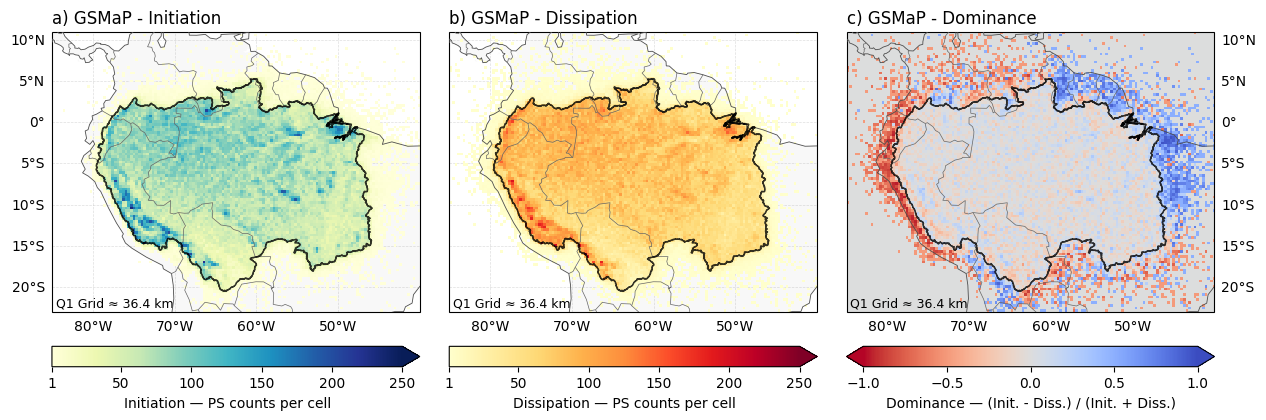

In [12]:
fig = plot_ps_initiation_dissipation_dominance(
    gsmap_amazon_traj_gpd,
    extent=[-85, -40, -23, 11],
    base_map=amazon,
    title='GSMaP',
    counts_log=False,
    q1_km=None,
    dominance_mode='asymmetry',
    vmax=250,
)

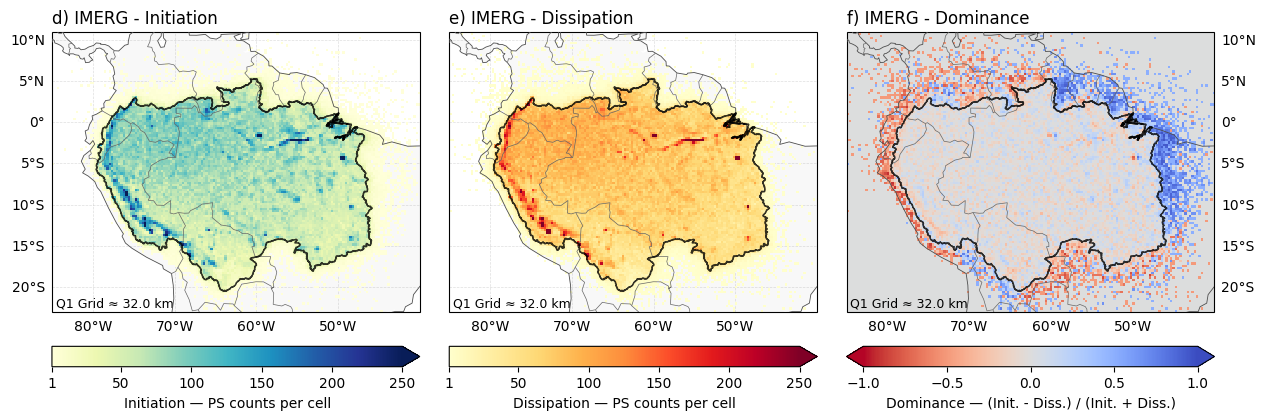

In [71]:
fig = plot_ps_initiation_dissipation_dominance(
    imerg_amazon_traj_gpd,
    extent=[-85, -40, -23, 11],
    base_map=amazon,
    title='IMERG',
    counts_log=False,
    q1_km=None,
    title_sequency=('d)', 'e)', 'f)'),
    dominance_mode='asymmetry',
    vmax=250
)

In [47]:
np.arange(25, 275, 10)

array([ 25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125, 135, 145,
       155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255, 265])

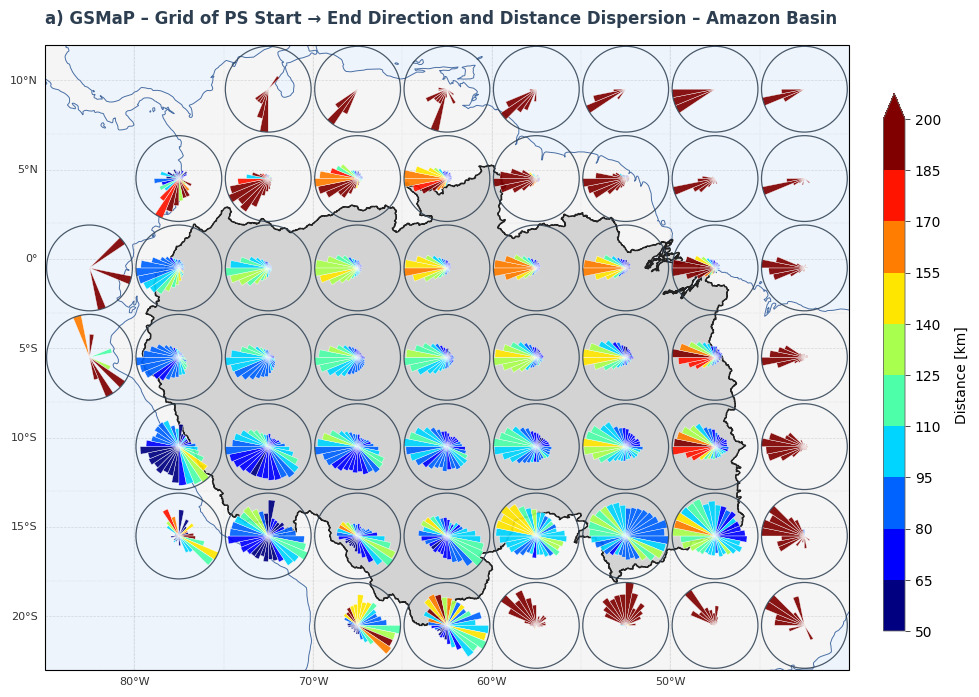

In [56]:
# Plot GSMAP
fig, ax = plot_windrose_grid(
    gsmap_amazon_traj_gpd,
    step=5, # degree grid step 
    extent=[-85, -40, -23, 12],
    dir_bins=32,       # number of direction sectors
    dist_stat="mean",  # statistic to summarize distance in each sector
    cmap="jet",
    radius_mode="frequency",
    gamma=0.9,
    min_radius_frac=0.08,
    cell_margin_frac=0.04,
    color_bins=np.arange(50, 215, 15),
    min_events_per_cell=3,
    base_map=amazon,  # GeoDataFrame
    base_map_style={"edgecolor":"#222", "facecolor":"lightgray", "linewidth":1, "alpha":1},
    draw_gridlabels=True,
    show_borders=False,
    show_top=False, show_left=True, show_right=False, show_bottom=True,
    gridline_kwargs={"linewidth":0.5, "color":"gray", "alpha":0.25, "linestyle":"--"},
    title="a) GSMaP – Grid of PS Start → End Direction and Distance Dispersion – Amazon Basin"
)

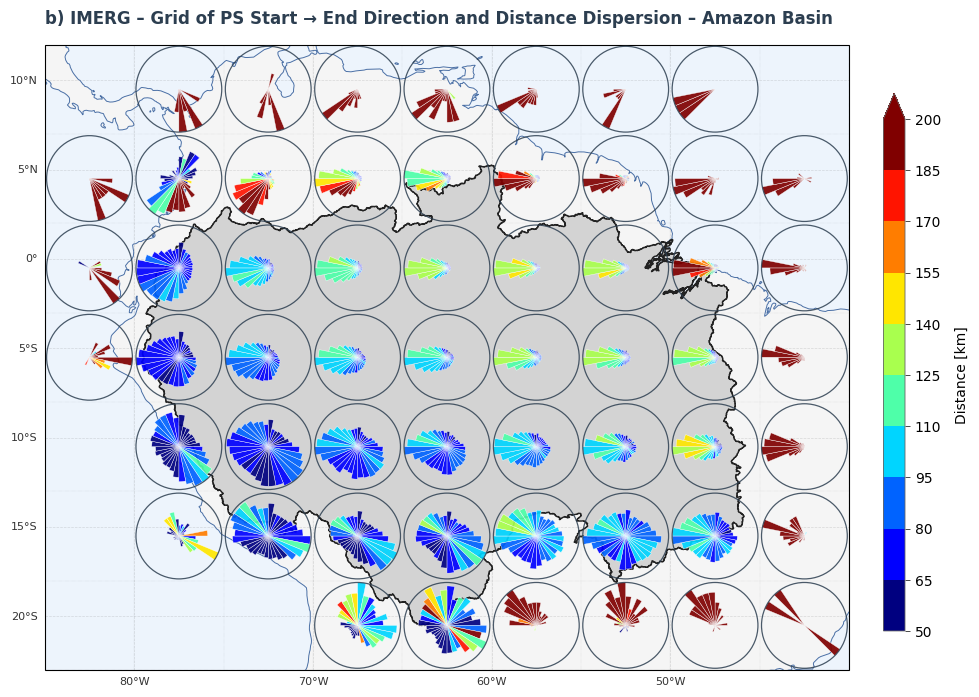

In [ ]:
# Plot IMERG
fig, ax = plot_windrose_grid(
    imerg_amazon_traj_gpd,
    step=5, # degree grid step 
    extent=[-85, -40, -23, 12],
    dir_bins=32,       # number of direction sectors
    dist_stat="mean",  # statistic to summarize distance in each sector
    cmap="jet",
    radius_mode="frequency",
    gamma=0.9,
    min_radius_frac=0.08,
    cell_margin_frac=0.04,
    color_bins=np.arange(50, 215, 15),
    min_events_per_cell=3,
    base_map=amazon,  # GeoDataFrame
    base_map_style={"edgecolor":"#222", "facecolor":"lightgray", "linewidth":1, "alpha":1},
    draw_gridlabels=True,
    show_borders=False,
    show_top=False, show_left=True, show_right=False, show_bottom=True,
    gridline_kwargs={"linewidth":0.5, "color":"gray", "alpha":0.25, "linestyle":"--"},
    title="b) IMERG – Grid of PS Start → End Direction and Distance Dispersion – Amazon Basin"
)

In [13]:
# Get spatial weighted mean time series for duration and precipitation
gsmap_ds_amz_duration = daskCompute(spatial_weighted_mean_series(gsmap_ds_amz['fam-duration'] / 60, gsmap_ds_amz['fam-density']), dask_client)
imerg_ds_amz_duration = daskCompute(spatial_weighted_mean_series(imerg_ds_amz['fam-duration'] / 60, imerg_ds_amz['fam-density']), dask_client)
# Get spatial weighted mean time series for precipitation
gsmap_ds_amz_precipitation = daskCompute(spatial_weighted_mean_series(gsmap_ds_amz['fam-mean_values'], gsmap_ds_amz['fam-density']), dask_client)
imerg_ds_amz_precipitation = daskCompute(spatial_weighted_mean_series(imerg_ds_amz['fam-mean_values'], imerg_ds_amz['fam-density']), dask_client)
# Get spatial weighted fam-u_ and fam-v_ time series
gsmap_ds_amz_famu = daskCompute(spatial_weighted_mean_series(gsmap_ds_amz['fam-u_'], gsmap_ds_amz['fam-density']), dask_client)
gsmap_ds_amz_famv = daskCompute(spatial_weighted_mean_series(gsmap_ds_amz['fam-v_'], gsmap_ds_amz['fam-density']), dask_client)
imerg_ds_amz_famu = daskCompute(spatial_weighted_mean_series(imerg_ds_amz['fam-u_'], imerg_ds_amz['fam-density']), dask_client)
imerg_ds_amz_famv = daskCompute(spatial_weighted_mean_series(imerg_ds_amz['fam-v_'], imerg_ds_amz['fam-density']), dask_client)

# Build monthly distance time series
gsmap_distance = build_monthly_distance(gsmap_amazon_traj_gpd,
                                 time_col="end_timestamp",
                                 dist_col="start_end_haversine_km",
                                 filter_max_km=None)
gsmap_distance.index.rename('time', inplace=True)

imerg_distance = build_monthly_distance(imerg_amazon_traj_gpd,
                                 time_col="end_timestamp",
                                 dist_col="start_end_haversine_km",
                                 filter_max_km=None)
imerg_distance.index.rename('time', inplace=True)

In [23]:
3600 / 2

1800.0

In [26]:
# Convert gsmap_ds_amz_famu and gsmap_ds_amz_famv to speeds in m/s, where the units are in degrees per hour
gsmap_ds_amz_famu_ = gsmap_ds_amz_famu * (111320) / 3600  # Convert to m/s
gsmap_ds_amz_famv_ = gsmap_ds_amz_famv * (111320) / 3600  # Convert to m/s
gsmap_ds_amz_speed = np.sqrt(gsmap_ds_amz_famu_**2 + gsmap_ds_amz_famv_**2)
gsmap_ds_amz_direction = np.arctan2(gsmap_ds_amz_famu_, gsmap_ds_amz_famv_) * (180 / np.pi) % 360

imerg_ds_amz_famu_ = imerg_ds_amz_famu * (111320) / 1800  # Convert to m/s
imerg_ds_amz_famv_ = imerg_ds_amz_famv * (111320) / 1800  # Convert to m/s
imerg_ds_amz_speed = np.sqrt(imerg_ds_amz_famu_**2 + imerg_ds_amz_famv_**2)
imerg_ds_amz_direction = np.arctan2(imerg_ds_amz_famu_, imerg_ds_amz_famv_) * (180 / np.pi) % 360

In [28]:
gsmap_distance['fam-duration'] = gsmap_ds_amz_duration.values
imerg_distance['fam-duration'] = imerg_ds_amz_duration.values
gsmap_distance['fam-precipitation'] = gsmap_ds_amz_precipitation.values
imerg_distance['fam-precipitation'] = imerg_ds_amz_precipitation.values
gsmap_distance['fam-speed'] = gsmap_ds_amz_speed.values
imerg_distance['fam-speed'] = imerg_ds_amz_speed.values
gsmap_distance['fam-direction'] = gsmap_ds_amz_direction.values
imerg_distance['fam-direction'] = imerg_ds_amz_direction.values

In [32]:
gsmap_distance[['mean','fam-duration','fam-precipitation','fam-speed','fam-direction']]

mean  fam-duration  fam-precipitation  fam-speed  \
time                                                                 
2015-01-01  105.276638     10.814443           0.857718   1.229109   
2015-02-01  110.796097      9.892594           0.794878   0.908088   
2015-03-01  107.813463     12.524004           1.031471   1.231358   
2015-04-01  122.882127     13.405387           1.030813   2.098201   
2015-05-01  128.217495     12.159510           0.723827   1.305084   
...                ...           ...                ...        ...   
2024-08-01  134.977622      3.218774           0.205347   0.709870   
2024-09-01  105.105548      4.145821           0.244977   0.688624   
2024-10-01  105.484915     13.669633           0.575434   0.130635   
2024-11-01  100.135759     10.515438           0.751651   0.797676   
2024-12-01  112.526266     11.984451           0.912970   1.252447   

            fam-direction  
time                       
2015-01-01     254.496204  
2015-02-01     254.199147  
2015-03-01     254.021985  
2015-04-01     247.579321  
2015-05-01     243.682474  
...                   ...  
2024-08-01     257.831839  
2024-09-01     262.459153  
2024-10-01     205.580488  
2024-11-01     252.173838  
2024-12-01     241.038881  

[120 rows x 5 columns]

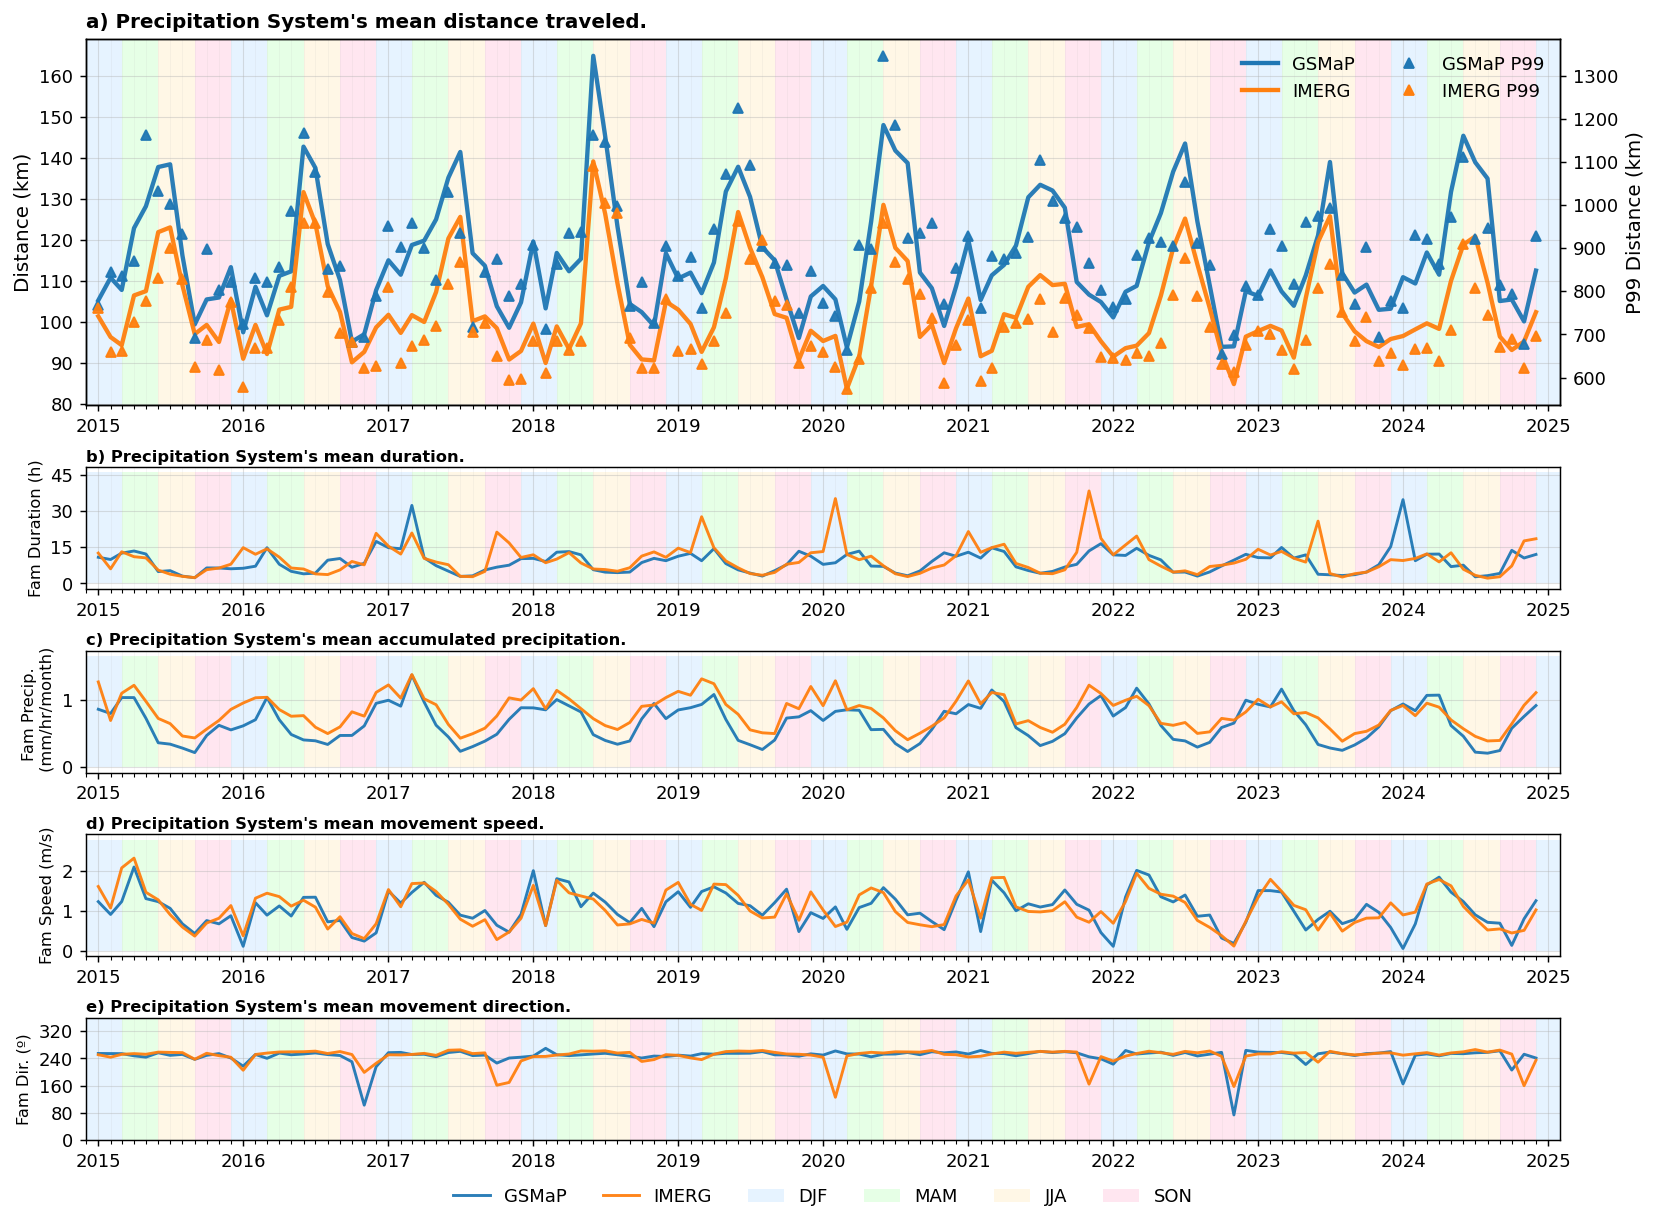

In [72]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# -----------------------------------------
# Utilitários
# -----------------------------------------
DATASET_COLORS = {"GSMaP": "#1f77b4", "IMERG": "#ff7f0e"}

UNITS = {
    'mean': "Distance (km)",
    'p99': "P99 Distance (km)",
    'fam-duration': "Fam Duration (h)",
    'fam-precipitation': "Fam Precip. \n (mm/hr/month)",
    'fam-speed': "Fam Speed (m/s)",
    'fam-direction': "Fam Dir. (º)",
}

def _ensure_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df.sort_index()

def _break_on_wrap(series_deg, threshold=360):
    s = pd.Series(series_deg, index=series_deg.index)
    d = s.diff().abs()
    s = s.copy()
    s[d > threshold] = np.nan
    return s

def _format_time_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, which='major', linewidth=0.6, alpha=0.4)
    ax.grid(True, which='minor', linewidth=0.3, alpha=0.2)

# -----------------------------------------
# Plot: foco em 'mean' + p99 no twin axis, com backgrounds externos
# -----------------------------------------
def plot_target_mean_with_p99_and_complements_bg(
    df_gsmap: pd.DataFrame,
    df_imerg: pd.DataFrame,
    *,
    target_col: str = 'mean',
    p99_col: str = 'p99',
    complement_cols = ('fam-duration','fam-precipitation','fam-speed','fam-direction'),
    figsize=(13.5, 10.2),
    dpi=130,
    enforce_integer_yticks=False,
    extended_start='2014-12-01',
    extended_end='2025-01-15',
    add_background_fn=None,         # passe plots.add_seasonal_backgrounds
):
    # --- índice temporal ---
    df_gsmap = _ensure_datetime_index(df_gsmap)
    df_imerg = _ensure_datetime_index(df_imerg)

    # --- checagens ---
    needed = [target_col, p99_col] + list(complement_cols)
    miss_g = [c for c in needed if c not in df_gsmap.columns]
    miss_i = [c for c in needed if c not in df_imerg.columns]
    if miss_g or miss_i:
        msgs = []
        if miss_g: msgs.append(f"GSMaP faltando: {miss_g}")
        if miss_i: msgs.append(f"IMERG faltando: {miss_i}")
        raise KeyError("Colunas ausentes: " + " | ".join(msgs))

    # --- séries brutas (sem smooth) ---
    g_target = df_gsmap[target_col]
    i_target = df_imerg[target_col]
    g_p99    = df_gsmap[p99_col]
    i_p99    = df_imerg[p99_col]

    # figura: alvo (3x) + complementos (1x cada)
    heights = [3] + [1]*len(complement_cols)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = GridSpec(len(heights), 1, height_ratios=heights)
    fig.subplots_adjust(wspace=0.15, hspace=0.36, left=0.08, right=0.92, top=0.96, bottom=0.13)

    # ---------------- Painel (a): target + p99 twin ----------------
    ax_t = fig.add_subplot(gs[0, 0])
    l_g, = ax_t.plot(g_target.index, g_target.values, lw=2.4, alpha=0.95,
                     color=DATASET_COLORS['GSMaP'], label='GSMaP')
    l_i, = ax_t.plot(i_target.index, i_target.values, lw=2.4, alpha=0.95,
                     color=DATASET_COLORS['IMERG'], label='IMERG')
    ax_t.set_ylabel(UNITS.get(target_col, target_col), fontsize=11)

    # twin axis: p99 com triângulos
    ax_p = ax_t.twinx()
    ax_p.plot(g_p99.index, g_p99.values, linestyle='none', marker='^', markersize=5,
              alpha=0.95, color=DATASET_COLORS['GSMaP'], label=f'GSMaP {p99_col.upper()}')
    ax_p.plot(i_p99.index, i_p99.values, linestyle='none', marker='^', markersize=5,
              alpha=0.95, color=DATASET_COLORS['IMERG'], label=f'IMERG {p99_col.upper()}')
    ax_p.set_ylabel(UNITS.get('p99', f"{p99_col.upper()}"), fontsize=11)

    _format_time_axis(ax_t)
    ax_t.text(0.0, 1.02, "a) Precipitation System's mean distance traveled.",
              transform=ax_t.transAxes, ha='left', va='bottom', fontsize=11, fontweight='bold')

    # limites de x conforme pedido
    ax_t.set_xlim(pd.to_datetime(extended_start), pd.to_datetime('2025-01-31'))

    # ---------------- Painéis complementares (b..e) ----------------
    axes_comp = []
    letters_start = ord('b')
    for k, col in enumerate(complement_cols):
        ax = fig.add_subplot(gs[1 + k, 0], sharex=ax_t)

        if col.lower() in ('fam-direction', 'direction', 'dir', 'wind_dir', 'fam_direction'):
            g = _break_on_wrap(df_gsmap[col].dropna())
            m = _break_on_wrap(df_imerg[col].dropna())
            ax.plot(g.index, g.values, lw=1.6, alpha=0.95, color=DATASET_COLORS['GSMaP'], label='GSMaP')
            ax.plot(m.index, m.values, lw=1.6, alpha=0.95, color=DATASET_COLORS['IMERG'], label='IMERG')
            ax.set_ylim(0, 360)
            ax.set_yticks([0, 90, 180, 270, 360])
        else:
            ax.plot(df_gsmap[col].index, df_gsmap[col].values, lw=1.6, alpha=0.95,
                    color=DATASET_COLORS['GSMaP'], label='GSMaP')
            ax.plot(df_imerg[col].index, df_imerg[col].values, lw=1.6, alpha=0.95,
                    color=DATASET_COLORS['IMERG'], label='IMERG')

        if enforce_integer_yticks:
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

        ax.set_ylabel(UNITS.get(col, col), fontsize=9)
        _format_time_axis(ax)
        letter = chr(letters_start + k)
        if col == 'fam-direction':
            text = f"{letter}) Precipitation System's mean movement direction."
        elif col == 'fam-duration':
            text = f"{letter}) Precipitation System's mean duration."
        elif col == 'fam-precipitation':
            text = f"{letter}) Precipitation System's mean accumulated precipitation."
        elif col == 'fam-speed':
            text = f"{letter}) Precipitation System's mean movement speed."
        else:
            text = f"{letter}) {col}"
        ax.text(0.0, 1.02, text,
                transform=ax.transAxes, ha='left', va='bottom', fontsize=9, fontweight='bold')
        axes_comp.append(ax)

    # locators (ano como major; mês como minor) em todos
    for ax in [ax_t] + axes_comp:
        _format_time_axis(ax)

    # --------- Background sazonal com sua função externa (todos os subplots) ---------
    season_colors = None
    if add_background_fn is not None:
        bg_axes = [ax_t] + axes_comp

        def _amax(series):
            return np.nanmax(series.values) if len(series) else np.nan

        mean_max = max(_amax(df_gsmap[target_col]), _amax(df_imerg[target_col])) * 1.1
        comp_ymax = {}
        if 'fam-duration' in df_gsmap.columns and 'fam-duration' in df_imerg.columns:
            comp_ymax['fam-duration'] = max(_amax(df_gsmap['fam-duration']),
                                            _amax(df_imerg['fam-duration'])) * 1.2
        if 'fam-precipitation' in df_gsmap.columns and 'fam-precipitation' in df_imerg.columns:
            comp_ymax['fam-precipitation'] = max(_amax(df_gsmap['fam-precipitation']),
                                                 _amax(df_imerg['fam-precipitation'])) * 1.2
        if 'fam-speed' in df_gsmap.columns and 'fam-speed' in df_imerg.columns:
            comp_ymax['fam-speed'] = max(_amax(df_gsmap['fam-speed']),
                                         _amax(df_imerg['fam-speed'])) * 1.2
        if 'fam-direction' in df_gsmap.columns and 'fam-direction' in df_imerg.columns:
            comp_ymax['fam-direction'] = 360.0

        def _fallback_max(col):
            return max(_amax(df_gsmap[col]), _amax(df_imerg[col])) * 1.1

        y_max_vals = [mean_max]
        for col in complement_cols:
            y_max_vals.append(comp_ymax[col] if col in comp_ymax else _fallback_max(col))

        season_colors = add_background_fn(
            bg_axes,
            pd.to_datetime(extended_start),
            pd.to_datetime(extended_end),
            y_max_vals
        )

    # --------- Legendas ---------
    custom_handles_a = [
        Line2D([0],[0], color=DATASET_COLORS['GSMaP'], lw=2.4, label='GSMaP'),
        Line2D([0],[0], color=DATASET_COLORS['IMERG'], lw=2.4, label='IMERG'),
        Line2D([0],[0], marker='^', linestyle='none', color=DATASET_COLORS['GSMaP'], label=f'GSMaP {p99_col.upper()}'),
        Line2D([0],[0], marker='^', linestyle='none', color=DATASET_COLORS['IMERG'], label=f'IMERG {p99_col.upper()}'),
    ]
    ax_t.legend(handles=custom_handles_a, ncols=2, loc='upper right', frameon=False, fontsize=10)

    if season_colors is not None:
        season_patches = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, alpha=1)
                          for color in season_colors.values()]
        last_ax = axes_comp[-1] if axes_comp else ax_t
        handles_last, labels_last = last_ax.get_legend_handles_labels()
        last_ax.legend(handles=handles_last + season_patches,
                       labels=labels_last + list(season_colors.keys()),
                       ncol=6, loc='lower center', bbox_to_anchor=(0.5, -0.6),
                       borderaxespad=0., frameon=False)

    # rótulo X no último painel (mantido vazio como no seu exemplo)
    if axes_comp:
        axes_comp[-1].set_xlabel("", fontsize=10)
    else:
        ax_t.set_xlabel("", fontsize=10)

    return fig


# -----------------------
# Exemplo de uso
# -----------------------
fig = plot_target_mean_with_p99_and_complements_bg(
    gsmap_distance,
    imerg_distance,
    target_col='mean', p99_col='p99',
    complement_cols=('fam-duration','fam-precipitation','fam-speed','fam-direction'),
    enforce_integer_yticks=True,
    extended_start='2014-12-01', extended_end='2025-01-15',
    add_background_fn=plots.add_seasonal_backgrounds
)
plt.show()


In [130]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

# Paletas e marcadores por estação (opcional)
SEASON_LABELS = {12:"DJF", 1:"DJF", 2:"DJF",
                 3:"MAM", 4:"MAM", 5:"MAM",
                 6:"JJA", 7:"JJA", 8:"JJA",
                 9:"SON",10:"SON",11:"SON"}
SEASON_ORDER  = ["DJF","MAM","JJA","SON"]
SEASON_COLORS = {"DJF": "#0077becc", "MAM": "#00cc44cc",
                 "JJA": "#ffcc00cc", "SON": "#ff66b2cc"}
SEASON_MARK   = {"DJF":"o", "MAM":"s", "JJA":"^", "SON":"D"}

# Rótulos/unidades (ajuste livre)
VAR_INFO = {
    'fam-precipitation': ("PS Precipitation", "mm/hr/month"),
    'fam-duration'     : ("PS Duration", "h"),
    'fam-speed'        : ("PS Speed", "m/s"),
    'fam-direction'    : ("PS Direction", "º"),
    'mean'             : ("Distance", "km"),
    'p99'              : ("P99 Distance", "km"),
}

def _ensure_dtindex(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df.sort_index()

def _prep(df: pd.DataFrame, needed_cols: set, color_by_season: bool) -> pd.DataFrame:
    df = _ensure_dtindex(df)
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Colunas ausentes no DataFrame: {missing}")
    out = df[list(needed_cols)].copy()
    if color_by_season:
        out["__season__"] = [SEASON_LABELS[m] for m in out.index.month]
    return out.dropna()

def _compute_lims(a: np.ndarray) -> tuple[float,float]:
    lo, hi = np.nanpercentile(a, [1, 99])
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = np.nanmin(a), np.nanmax(a)
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    return lo - pad, hi + pad

def _reg_line(ax, x, y, color="0.25"):
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3: return
    b1, b0 = np.polyfit(x[m], y[m], 1)     # y = b1*x + b0
    xx = np.linspace(x[m].min(), x[m].max(), 120)
    ax.plot(xx, b1*xx + b0, lw=1.0, ls='--', color=color, alpha=0.9)

def _annot_stats(ax, x, y, where="upper right"):
    m = np.isfinite(x) & np.isfinite(y)
    txt = "r=–, ρ=–"
    if m.sum() >= 3:
        r   = np.corrcoef(x[m], y[m])[0,1]
        rho = pd.Series(x[m]).corr(pd.Series(y[m]), method="spearman")
        txt = f"r={r:.2f}, ρ={rho:.2f}"
    pos = {"lower right":(0.98, 0.02, "right","bottom"),
           "lower left": (0.02, 0.02, "left", "bottom"),
           "upper right":(0.98, 0.98,"right","top"),
           "upper left": (0.02, 0.98,"left", "top")}
    x0, y0, ha, va = pos[where]
    ax.text(x0, y0, txt, transform=ax.transAxes, ha=ha, va=va, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

def plot_pair_grid(
    df_gsmap: pd.DataFrame,
    df_imerg: pd.DataFrame,
    pairs: list[tuple[str, str]],
    *,
    figsize=(11.5, 10.0),
    dpi=110,
    color_by_season=True,
    harmonize_limits=True,
    point_size=24,
    alpha_points=0.95,
    show_season_legend=True,
):
    """
    Gera N linhas × 2 colunas (GSMaP | IMERG), um painel por par (x_col, y_col).
    'pairs' usa NOME REAL de COLUNA dos seus DataFrames (ex. 'fam-precipitation','mean').
    """
    # colunas necessárias
    needed = set([c for p in pairs for c in p])
    df_g = _prep(df_gsmap, needed, color_by_season)
    df_i = _prep(df_imerg, needed, color_by_season)

    # limites por variável (por base)
    lims_g = {c: _compute_lims(df_g[c].to_numpy()) for c in needed}
    lims_i = {c: _compute_lims(df_i[c].to_numpy()) for c in needed}
    lims   = {}
    for c in needed:
        if harmonize_limits:
            lims[c] = (min(lims_g[c][0], lims_i[c][0]), max(lims_g[c][1], lims_i[c][1]))
        else:
            lims[c] = lims_g[c]

    # figura
    n = len(pairs)
    fig, axes = plt.subplots(n, 2, figsize=figsize, dpi=dpi, sharex=False, sharey=False)
    if n == 1:
        axes = np.array([axes])  # normaliza forma

    # rótulos a), b), ...
    labels = [chr(ord('a') + k) + ")" for k in range(2*n)]

    # loop de painéis
    for i, (xcol, ycol) in enumerate(pairs):
        # textos (nome + unidade)
        xname, xunit = VAR_INFO.get(xcol, (xcol, "")); xlab = f"{xname}" + (f" ({xunit})" if xunit else "")
        yname, yunit = VAR_INFO.get(ycol, (ycol, "")); ylab = f"{yname}" + (f" ({yunit})" if yunit else "")

        # ---------- GSMaP (coluna esquerda) ----------
        axL = axes[i, 0]
        x = df_g[xcol].to_numpy(); y = df_g[ycol].to_numpy()
        if color_by_season:
            for s in SEASON_ORDER:
                m = (df_g["__season__"].values == s)
                if not np.any(m): continue
                axL.scatter(x[m], y[m], s=point_size, alpha=alpha_points,
                            marker=SEASON_MARK[s], color=SEASON_COLORS[s], edgecolor="none",
                            label=s if (show_season_legend and i == 0) else None)
        else:
            axL.scatter(x, y, s=point_size, alpha=alpha_points, color="#1f77b4", edgecolor="none")

        _reg_line(axL, x, y); _annot_stats(axL, x, y)
        axL.set_xlim(lims[xcol]); axL.set_ylim(lims[ycol])
        axL.set_xlabel(xlab);    axL.set_ylabel(ylab)
        axL.set_title(f"{labels[2*i]} GSMaP: {xname} × {yname}", fontsize=10.5, loc="left")
        axL.xaxis.set_major_locator(MaxNLocator(nbins=7)); axL.yaxis.set_major_locator(MaxNLocator(nbins=7))
        axL.xaxis.set_minor_locator(AutoMinorLocator(2));  axL.yaxis.set_minor_locator(AutoMinorLocator(2))
        axL.grid(True, which="major", alpha=0.25); axL.grid(True, which="minor", alpha=0.12)
        axL.spines[['top','right']].set_visible(False)

        # ---------- IMERG (coluna direita) ----------
        axR = axes[i, 1]
        x = df_i[xcol].to_numpy(); y = df_i[ycol].to_numpy()
        if color_by_season:
            for s in SEASON_ORDER:
                m = (df_i["__season__"].values == s)
                if not np.any(m): continue
                axR.scatter(x[m], y[m], s=point_size, alpha=alpha_points,
                            marker=SEASON_MARK[s], color=SEASON_COLORS[s], edgecolor="none")
        else:
            axR.scatter(x, y, s=point_size, alpha=alpha_points, color="#ff7f0e", edgecolor="none")

        _reg_line(axR, x, y); _annot_stats(axR, x, y)
        axR.set_xlim(lims[xcol]); axR.set_ylim(lims[ycol])
        axR.set_xlabel(xlab);  axR.tick_params(labelleft=False)
        axR.set_title(f"{labels[2*i+1]} IMERG: {xname} × {yname}", fontsize=10.5, loc="left")
        axR.xaxis.set_major_locator(MaxNLocator(nbins=7)); axR.yaxis.set_major_locator(MaxNLocator(nbins=7))
        axR.xaxis.set_minor_locator(AutoMinorLocator(2));  axR.yaxis.set_minor_locator(AutoMinorLocator(2))
        axR.grid(True, which="major", alpha=0.25); axR.grid(True, which="minor", alpha=0.12)
        axR.spines[['top','right']].set_visible(False)

    # legenda global por estação (opcional)
    if color_by_season and show_season_legend:
        handles = [plt.Line2D([0],[0], marker=SEASON_MARK[s], linestyle='',
                              markersize=6, label=s, color=SEASON_COLORS[s]) for s in SEASON_ORDER]
        fig.legend(handles=handles, loc="upper center", ncol=4, frameon=True, framealpha=1,
                   bbox_to_anchor=(0.52, 0.01))
        plt.subplots_adjust(top=0.95)
    else:
        plt.subplots_adjust(top=0.98)

    plt.tight_layout()
    return fig, axes


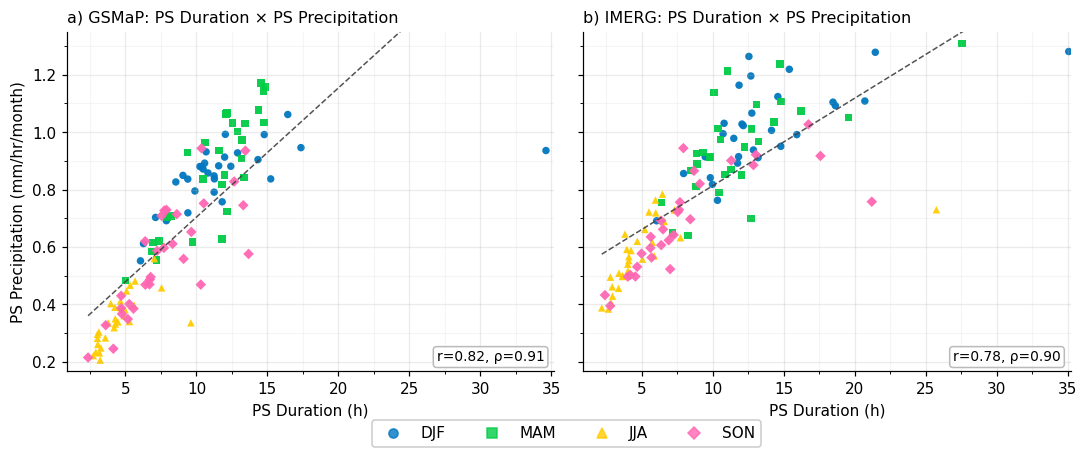

In [111]:
pairs = [
    ('fam-duration', 'fam-precipitation'),
    # ('fam-duration', 'mean'),
    # ('fam-duration','mean'),
    # ('fam-speed','mean'),
]

fig, axes = plot_pair_grid(
    gsmap_distance, imerg_distance,
    pairs=pairs,
    figsize=(10, 4),
    dpi=110,
    color_by_season=True,     # desative se quiser uma cor única
    harmonize_limits=True,    # compara escalas GSMaP vs IMERG
)
plt.show()


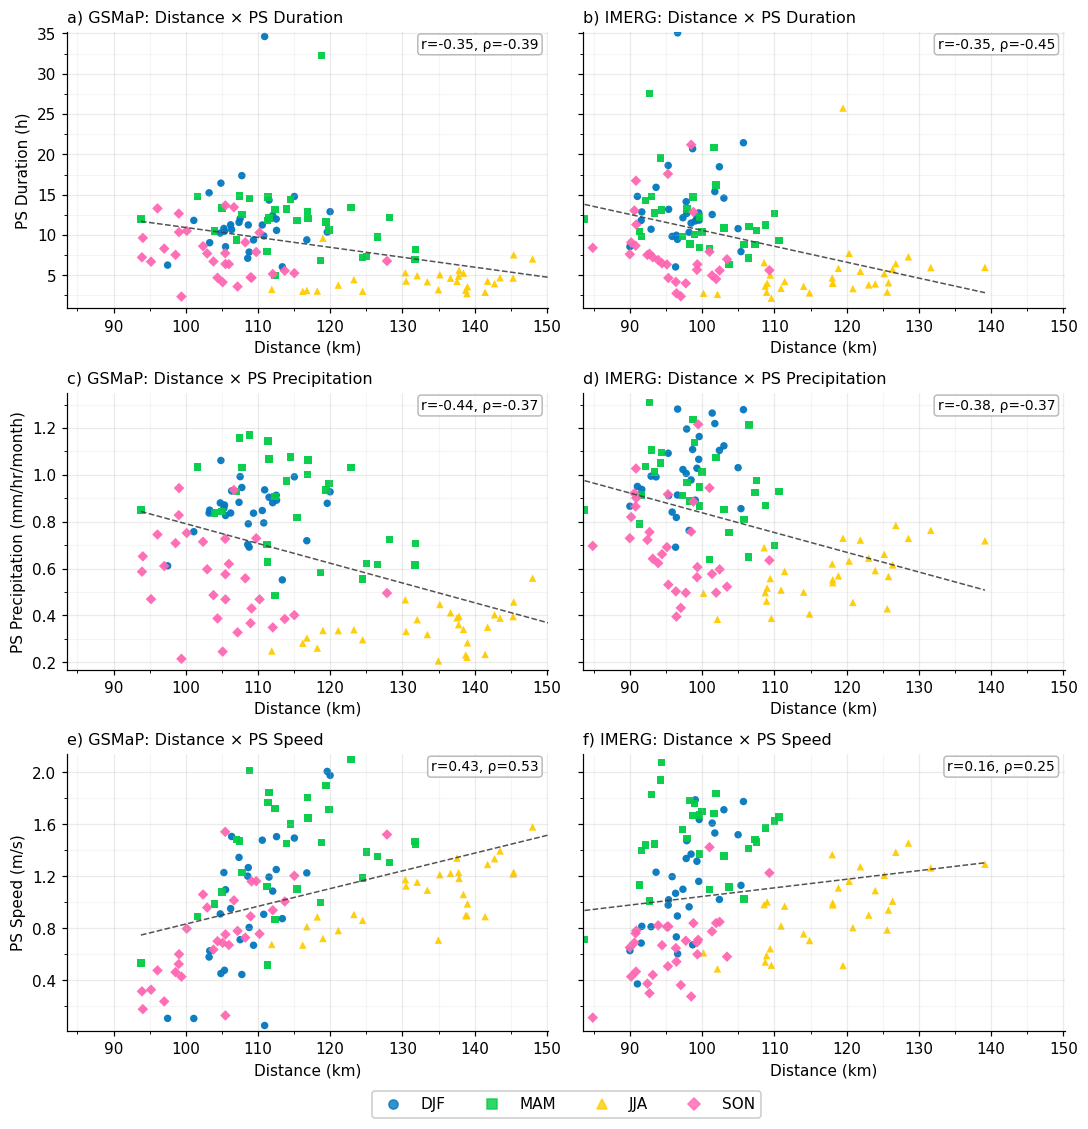

In [131]:
pairs = [
    ('mean','fam-duration'),
    ('mean','fam-precipitation'),
    ('mean','fam-speed'),
]

fig, axes = plot_pair_grid(
    gsmap_distance, imerg_distance,
    pairs=pairs,
    figsize=(10, 10),
    dpi=110,
    color_by_season=True,
    harmonize_limits=True,
)
plt.show()


In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator, AutoMinorLocator


def plot_distance_block(
    df: pd.DataFrame,
    ax_placeholder: plt.Axes,
    *,
    # colunas (None = não plota)
    mean_col: str | None = "mean",
    std_col:  str | None = "std",
    p99_col:  str | None = "p99",
    n_col:    str | None = "n",
    dur_col:  str | None = "fam-duration",
    prec_col: str | None = "fam-precipitation",
    # rótulos
    mean_label="Mean Distance (km)", p99_label="P99 Dist. (km)",
    n_label="Events (n)", dur_label="Fam. Duration (hr)", prec_label="Fam. Precipitation (mm)",
    # estética
    mean_color="tab:blue", p99_color="tab:cyan", n_color="tab:gray",
    dur_color="tab:green", prec_color="tab:orange",
    marker_mean="o", marker_p99="^",
    lw_mean=1.4, lw_dur=1.1, lw_prec=1.2,
    err_alpha=0.5, err_capsize=0, err_linewidth=1.0,
    p99_size=34, p99_edge=1.0, bar_alpha=0.25,
    # layout
    height_ratios=(4, 1.6), hspace=0.07,
    # sazonal (apenas no painel inferior)
    seasonal: bool = False,
    seasonal_func=None,                   # ex.: plots.add_seasonal_backgrounds
    seasonal_start: pd.Timestamp | None = None,
    seasonal_end:   pd.Timestamp | None = None,
    seasonal_ymax:  float | None = None, # se None, usa ylim do eixo inferior (esquerdo)
    add_season_legend: bool = True,
    # limites e ticks
    xlim: tuple | None = None,
    top_ylim: tuple | None = None,
    bottom_left_ylim: tuple | None = None,
    bottom_right_ylim: tuple | None = None,
    year_ticks_on_bottom: bool = True
):
    # --- índice e ordenação
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    x_dt  = df.index.to_pydatetime()
    x_num = mdates.date2num(x_dt)

    # --- subgrid
    fig = ax_placeholder.figure
    subspec = ax_placeholder.get_subplotspec()
    ax_placeholder.remove()
    have_bottom = (dur_col is not None) or (prec_col is not None)

    if have_bottom:
        gs = subspec.subgridspec(2, 1, height_ratios=height_ratios, hspace=hspace)
        ax_top = fig.add_subplot(gs[0, 0])
        ax_bot = fig.add_subplot(gs[1, 0], sharex=ax_top)
        ax_bot_r = ax_bot.twinx()
    else:
        gs = subspec.subgridspec(1, 1)
        ax_top = fig.add_subplot(gs[0, 0])
        ax_bot = ax_bot_r = None

    # ===== TOPO =====
    handles_top, labels_top = [], []

    # mean + erro superior
    if mean_col and mean_col in df.columns:
        y_mean = df[mean_col].to_numpy()
        (ln_mean,) = ax_top.plot(
            x_dt, y_mean, color=mean_color, marker=marker_mean, markersize=3,
            linewidth=lw_mean, label=mean_label, zorder=3
        )
        handles_top.append(ln_mean); labels_top.append(mean_label)

        if std_col and std_col in df.columns:
            upper = df[std_col].to_numpy()
            ax_top.errorbar(
                x_dt, y_mean, yerr=[np.zeros_like(upper), upper], fmt="none",
                ecolor=mean_color, elinewidth=err_linewidth,
                capsize=err_capsize, alpha=err_alpha, zorder=2
            )

    # ---- p99 (marcadores)
    ax_top_p99 = None
    if p99_col and p99_col in df.columns:
        if p99_color is None:
            p99_color = mean_color
        ax_top_p99 = ax_top.twinx()
        (ln_p99,) = ax_top_p99.plot(
            x_dt, df[p99_col].to_numpy(), color=p99_color,
            marker=marker_p99, markersize=5, linewidth=0,
            label=p99_label, zorder=4
        )
        ax_top_p99.set_ylabel(p99_label, color=p99_color)
        handles_top.append(ln_p99); labels_top.append(p99_label)

    # ---- n (barras) no twinx deslocado
    ax_top_nspine = None
    if n_col and n_col in df.columns:
        ax_top_nspine = ax_top.twinx()
        ax_top_nspine.spines["right"].set_position(("axes", 1.08))
        ax_top_nspine.set_frame_on(True)
        ax_top_nspine.patch.set_visible(False)
        for sp in ax_top_nspine.spines.values():
            sp.set_visible(True)

        bar_w = 0.8 * np.median(np.diff(x_num)) if len(x_num) >= 2 else 20.0
        ax_top_nspine.bar(
            x_dt, df[n_col].to_numpy(), width=bar_w, align="center",
            color=n_color, alpha=bar_alpha, edgecolor="none",
            label=n_label, zorder=1
        )
        ax_top_nspine.set_ylabel(n_label, color=n_color)
        handles_top.append(Patch(facecolor=n_color, alpha=bar_alpha, edgecolor="none"))
        labels_top.append(n_label)

    # estética topo
    if mean_col:
        ax_top.set_ylabel(mean_label)
    if top_ylim is not None:
        ax_top.set_ylim(*top_ylim)
    if xlim is not None:
        ax_top.set_xlim(*xlim)
    ax_top.grid(True, linestyle="--", alpha=0.35)
    locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
    ax_top.xaxis.set_major_locator(locator)
    ax_top.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    if handles_top:
        ax_top.legend(handles_top, labels_top, loc="upper right", frameon=True, ncol=3)

    # ===== INFERIOR =====
    season_colors = None
    if have_bottom:
        handles_bot, labels_bot = [], []

        if dur_col and dur_col in df.columns:
            (ln_dur,) = ax_bot.plot(
                x_dt, df[dur_col].to_numpy(), color=dur_color,
                linestyle="--", linewidth=lw_dur, label=dur_label
            )
            handles_bot.append(ln_dur); labels_bot.append(dur_label)
            ax_bot.set_ylabel(dur_label, fontsize=8)

        if prec_col and prec_col in df.columns:
            (ln_prec,) = ax_bot_r.plot(
                x_dt, df[prec_col].to_numpy(), color=prec_color,
                linestyle=":", linewidth=lw_prec, label=prec_label
            )
            handles_bot.append(ln_prec); labels_bot.append(prec_label)
            ax_bot_r.set_ylabel(prec_label, fontsize=8)

        # limites antes do sazonal
        if bottom_left_ylim is not None:  ax_bot.set_ylim(*bottom_left_ylim)
        if bottom_right_ylim is not None: ax_bot_r.set_ylim(*bottom_right_ylim)
        if xlim is not None:              ax_bot.set_xlim(*xlim)

        # sazonal (apenas no painel inferior)
        if seasonal and callable(seasonal_func) and (seasonal_start is not None) and (seasonal_end is not None):
            y_max_val = seasonal_ymax if seasonal_ymax is not None else ax_bot.get_ylim()[1]
            season_colors = seasonal_func([ax_bot], seasonal_start, seasonal_end, [y_max_val]) or None

        if year_ticks_on_bottom:
            ax_bot.xaxis.set_major_locator(mdates.YearLocator())
            ax_bot.xaxis.set_minor_locator(mdates.MonthLocator())

        ax_bot.grid(True, axis="y", linestyle=":", alpha=0.25)
        plt.setp(ax_top.get_xticklabels(), visible=False)

        if handles_bot:
            if add_season_legend and isinstance(season_colors, dict) and season_colors:
                season_patches = [Patch(facecolor=c, edgecolor="none") for c in season_colors.values()]
                handles_bot += season_patches
                labels_bot  += list(season_colors.keys())
            ax_bot.legend(
                handles_bot, labels_bot, loc="lower center",
                frameon=True, ncol=6, bbox_to_anchor=(0.5, -.8)
            )

    return {
        "ax_top": ax_top,
        "ax_top_p99": ax_top_p99,        # p99 -> marcadores
        "ax_top_nspine": ax_top_nspine,  # n -> barras com spine deslocado
        "ax_bottom": ax_bot,
        "ax_bottom_right": ax_bot_r,
        "season_colors": season_colors
    }



def sync_blocks(gsmap_axes: dict, imerg_axes: dict, *,
                sync_x: bool = True,
                nbins_left: int = 6,
                nbins_right: int = 6,
                nbins_top_left: int = 6,
                nbins_top_right: int = 6):

    def _pairwise_ylim(ax1, ax2):
        if ax1 is None or ax2 is None:
            return
        lo = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
        hi = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
        ax1.set_ylim(lo, hi)
        ax2.set_ylim(lo, hi)

    def _pairwise_xlim(ax1, ax2):
        if ax1 is None or ax2 is None:
            return
        lo = min(ax1.get_xlim()[0], ax2.get_xlim()[0])
        hi = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(lo, hi)
        ax2.set_xlim(lo, hi)

    def _first(axdict: dict, keys: list[str]):
        """Retorna o primeiro eixo existente e não-None dentre as chaves dadas."""
        for k in keys:
            ax = axdict.get(k, None)
            if ax is not None:
                return ax
        return None

    # --- pares a sincronizar ---
    ax_top_L_g = gsmap_axes.get("ax_top", None)
    ax_top_L_i = imerg_axes.get("ax_top", None)

    # p99 (prioriza nova chave, cai para a antiga se existir)
    ax_top_p99_g = _first(gsmap_axes, ["ax_top_p99", "ax_top_right"])
    ax_top_p99_i = _first(imerg_axes, ["ax_top_p99", "ax_top_right"])

    # n (spine deslocada)
    ax_top_n_g = gsmap_axes.get("ax_top_nspine", None)
    ax_top_n_i = imerg_axes.get("ax_top_nspine", None)

    # base
    ax_bot_L_g = gsmap_axes.get("ax_bottom", None)
    ax_bot_L_i = imerg_axes.get("ax_bottom", None)

    ax_bot_R_g = gsmap_axes.get("ax_bottom_right", None)
    ax_bot_R_i = imerg_axes.get("ax_bottom_right", None)

    # 1) Igualar Y em todos os pares relevantes
    _pairwise_ylim(ax_top_L_g, ax_top_L_i)       # mean (esquerda)
    _pairwise_ylim(ax_top_p99_g, ax_top_p99_i)   # p99 (direita padrão)
    _pairwise_ylim(ax_top_n_g,  ax_top_n_i)      # n (spine deslocada)

    _pairwise_ylim(ax_bot_L_g, ax_bot_L_i)       # duration (esquerda)
    _pairwise_ylim(ax_bot_R_g, ax_bot_R_i)       # precipitation (direita)

    # 2) (Opcional) Igualar X (tempo)
    if sync_x:
        _pairwise_xlim(ax_top_L_g, ax_top_L_i)
        _pairwise_xlim(ax_bot_L_g, ax_bot_L_i)
        _pairwise_xlim(ax_top_p99_g, ax_top_p99_i)
        _pairwise_xlim(ax_top_n_g,  ax_top_n_i)
        _pairwise_xlim(ax_bot_R_g, ax_bot_R_i)

    # 3) Uniformizar densidade de ticks
    if ax_top_L_g and ax_top_L_i:
        for ax in (ax_top_L_g, ax_top_L_i):
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins_top_left))
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    if ax_top_p99_g and ax_top_p99_i:
        for ax in (ax_top_p99_g, ax_top_p99_i):
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins_top_right))
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    if ax_top_n_g and ax_top_n_i:
        for ax in (ax_top_n_g, ax_top_n_i):
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins_top_right))
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    if ax_bot_L_g and ax_bot_L_i:
        for ax in (ax_bot_L_g, ax_bot_L_i):
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins_left))
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    if ax_bot_R_g and ax_bot_R_i:
        for ax in (ax_bot_R_g, ax_bot_R_i):
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins_right))
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))


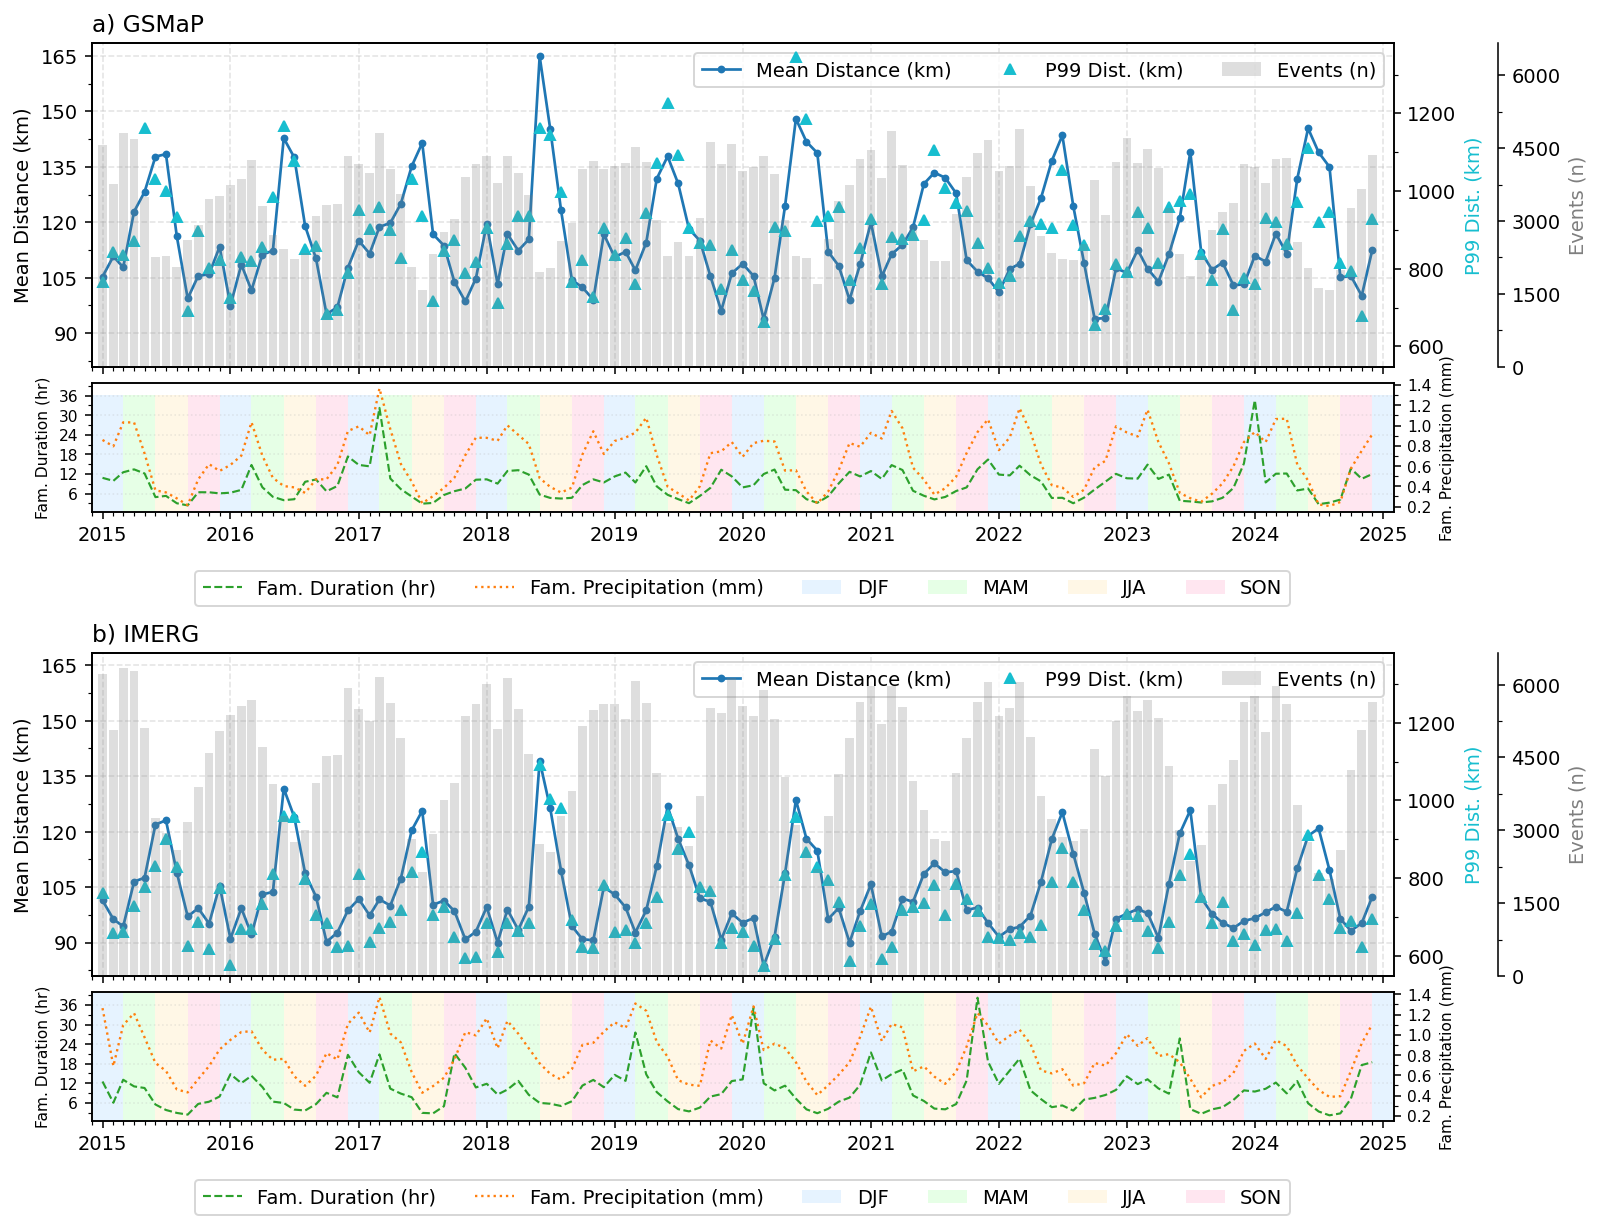

In [205]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=140, sharex=True)
plt.subplots_adjust(hspace=0.3)

ext_start = pd.Timestamp("2014-12-01")
ext_end   = pd.Timestamp("2025-01-31")

# Dica: pegue ymax do painel inferior a partir dos dados para o fundo sazonal
ymax_dur_gsmap = float(np.nanmax(gsmap_distance["fam-duration"])) * 1.05
ymax_dur_imerg = float(np.nanmax(imerg_distance["fam-duration"])) * 1.05

gsmap_axes = plot_distance_block(
    gsmap_distance, axs[0],
    mean_col="mean", std_col=None, p99_col="p99", n_col="n",
    dur_col="fam-duration", prec_col="fam-precipitation",
    seasonal=True, seasonal_func=plots.add_seasonal_backgrounds,
    seasonal_start=ext_start, seasonal_end=ext_end,
    xlim=(ext_start, ext_end),
)

gsmap_axes["ax_top"].set_title("a) GSMaP", loc="left", y=1)

imerg_axes = plot_distance_block(
    imerg_distance, axs[1],
    mean_col="mean", std_col=None, p99_col="p99", n_col="n",
    dur_col="fam-duration", prec_col="fam-precipitation",
    seasonal=True, seasonal_func=plots.add_seasonal_backgrounds,
    seasonal_start=ext_start, seasonal_end=ext_end,
    xlim=(ext_start, ext_end),
)

imerg_axes["ax_top"].set_title("b) IMERG", loc="left", y=1)


sync_blocks(gsmap_axes, imerg_axes, sync_x=True,
            nbins_left=7, nbins_right=7, nbins_top_left=6, nbins_top_right=5)

for axset in [gsmap_axes, imerg_axes]:
    axset["ax_bottom"].tick_params(axis="y", labelsize=8)
    axset["ax_bottom_right"].tick_params(axis="y", labelsize=8)


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

# ==============================
# Parâmetros
# ==============================
FIGSIZE         = (10.5, 10.0)
DPI             = 100
VARS            = ["Duration", "Precipitation", "Distance"]
PAIRS           = [("Duration","Precipitation"),
                   ("Duration","Distance"),
                   ("Precipitation","Distance")]
COLOR_GSMAP     = "#1f77b4"
COLOR_IMERG     = "#ff7f0e"
ALPHA_POINTS    = 1
S               = 22
EDGELESS        = dict(edgecolor="none")
MAX_POINTS      = None                   # defina p/ amostrar se necessário
HARMONIZE_LIMITS= True
COLOR_BY_SEASON = True

SEASON_LABELS   = {12:"DJF", 1:"DJF", 2:"DJF",
                   3:"MAM", 4:"MAM", 5:"MAM",
                   6:"JJA", 7:"JJA", 8:"JJA",
                   9:"SON",10:"SON",11:"SON"}
SEASON_ORDER    = ["DJF","MAM","JJA","SON"]
SEASON_COLORS = {
    "DJF": "#0077becc",  # azul-mar vivo (com alpha ~0.8)
    "MAM": "#00cc44cc",  # verde vibrante
    "JJA": "#ffcc00cc",  # amarelo intenso
    "SON": "#ff66b2cc",  # rosa magenta suave
}
SEASON_MARK     = {"DJF":"o", "MAM":"s", "JJA":"^", "SON":"D"}

# ==============================
# Helpers de preparação (DataFrame-only)
# ==============================
def prep_scatter_df(monthly_df: pd.DataFrame, cols: dict) -> pd.DataFrame:
    """
    monthly_df: DataFrame mensal com índice datetime-like.
    cols: mapeamento {'Duration': 'fam-duration', 'Precipitation':'fam-precipitation', 'Distance':'mean'}
    Retorna DF com colunas padronizadas + coluna 'season'.
    """
    if not isinstance(monthly_df.index, pd.DatetimeIndex):
        df = monthly_df.copy()
        df.index = pd.to_datetime(df.index)
    else:
        df = monthly_df.copy()

    # Seleciona e renomeia
    missing = [c for c in cols.values() if c not in df.columns]
    if missing:
        raise KeyError(f"As colunas {missing} não estão em monthly_df.columns")

    out = df[list(cols.values())].rename(columns={v:k for k,v in cols.items()})
    out = out.dropna()

    # adiciona estação
    out["season"] = [SEASON_LABELS[m] for m in out.index.month]
    return out

def subsample_df(df, max_points=MAX_POINTS, seed=42):
    if (max_points is None) or (len(df) <= max_points):
        return df
    return df.sample(n=max_points, random_state=seed)

def compute_lims(df):
    lims = {}
    for v in VARS:
        a = df[v].to_numpy()
        # percentis robustos
        lo, hi = np.nanpercentile(a, [1, 99])
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            lo, hi = np.nanmin(a), np.nanmax(a)
        pad = 0.05 * (hi - lo if hi > lo else 1.0)
        lims[v] = (lo - pad, hi + pad)
    return lims

def merge_lims(A, B):
    out = {}
    for v in VARS:
        out[v] = (min(A[v][0], B[v][0]), max(A[v][1], B[v][1]))
    return out

# ==============================
# Helpers de plot
# ==============================
def add_reg_line(ax, x, y, color="0.25"):
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3:
        return
    b1, b0 = np.polyfit(x[m], y[m], 1)   # y = b1*x + b0
    xx = np.linspace(x[m].min(), x[m].max(), 100)
    ax.plot(xx, b1*xx + b0, lw=1.1, ls='--', color=color, alpha=0.9)

def annotate_stats(ax, x, y, where="lower right"):
    s = pd.Series(x).dropna(); t = pd.Series(y).dropna()
    # alinhar por índice se x/y vierem de Series; aqui são arrays -> use correlação direta
    if len(s) == 0 or len(t) == 0 or len(s) != len(t):
        # fallback simples
        m = np.isfinite(x) & np.isfinite(y)
        if m.sum() < 3:
            txt = "r=–, ρ=–"
        else:
            r   = np.corrcoef(x[m], y[m])[0,1]
            rho = pd.Series(x[m]).corr(pd.Series(y[m]), method="spearman")
            txt = f"r={r:.2f}, ρ={rho:.2f}"
    else:
        r   = s.corr(t, method="pearson")
        rho = s.corr(t, method="spearman")
        txt = f"r={r:.2f}, ρ={rho:.2f}"

    pos = {"lower right":(0.98, 0.02, "right","bottom"),
           "lower left": (0.02, 0.02, "left", "bottom"),
           "upper right":(0.98, 0.98,"right","top"),
           "upper left": (0.02, 0.98,"left", "top")}
    x0, y0, ha, va = pos[where]
    ax.text(x0, y0, txt, transform=ax.transAxes, ha=ha, va=va, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

def scatter_panel(ax, df, xvar, yvar, lims, base_color, add_legend=False, subtitle=None):
    x = df[xvar].to_numpy()
    y = df[yvar].to_numpy()

    # pontos
    if COLOR_BY_SEASON:
        for s in SEASON_ORDER:
            m = (df["season"].values == s)
            if not np.any(m): 
                continue
            ax.scatter(x[m], y[m], s=S, alpha=ALPHA_POINTS, marker=SEASON_MARK[s],
                       color=SEASON_COLORS[s], **EDGELESS, label=s if add_legend else None)
    else:
        ax.scatter(x, y, s=S, alpha=ALPHA_POINTS, color=base_color, **EDGELESS)

    # reta OLS e estatísticas
    add_reg_line(ax, x, y, color="0.25")
    annotate_stats(ax, x, y, where="lower right")

    # limites e estilo
    ax.set_xlim(lims[xvar]); ax.set_ylim(lims[yvar])
    ax.xaxis.set_major_locator(MaxNLocator(nbins=7))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=7))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.grid(True, which="major", alpha=0.25)
    ax.grid(True, which="minor", alpha=0.12)
    ax.spines[['top','right']].set_visible(False)

    if subtitle:
        ax.set_title(subtitle, fontsize=10.5, loc="left")

# Mapeie as colunas do seu DF mensal para os nomes padronizados:
COLMAP_GSMAP = {"Duration": "fam-duration",
                "Precipitation": "fam-precipitation",
                "Distance": "mean"}

COLMAP_IMERG = {"Duration": "fam-duration",
                "Precipitation": "fam-precipitation",
                "Distance": "mean"}

df_gsm = subsample_df(prep_scatter_df(gsmap_distance, COLMAP_GSMAP), MAX_POINTS)
df_ime = subsample_df(prep_scatter_df(imerg_distance, COLMAP_IMERG), MAX_POINTS)

lims_g = compute_lims(df_gsm)
lims_i = compute_lims(df_ime)
lims   = merge_lims(lims_g, lims_i) if HARMONIZE_LIMITS else lims_g

# ==============================
# Figura: 3 linhas (pares) × 2 colunas (GSMaP | IMERG)
# ==============================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=FIGSIZE, dpi=DPI, sharex=False, sharey=False)

# Rótulos a) … f)
panel_labels = ["a)", "b)", "c)", "d)", "e)", "f)"]
panel_text   = [
    "GSMaP: Duration × Precipitation",
    "IMERG: Duration × Precipitation",
    "GSMaP: Duration × Distance",
    "IMERG: Duration × Distance",
    "GSMaP: Precipitation × Distance",
    "IMERG: Precipitation × Distance",
]

k = 0
for i, (xv, yv) in enumerate(PAIRS):
    # Esquerda: GSMaP
    subtitle_L = f"{panel_labels[k]} {panel_text[k]}"; k += 1
    scatter_panel(axes[i, 0], df_gsm, xv, yv, lims, base_color=COLOR_GSMAP,
                  add_legend=(COLOR_BY_SEASON and i == 0), subtitle=subtitle_L)
    axes[i, 0].set_ylabel(yv)
    axes[i, 0].set_xlabel(xv)

    # Direita: IMERG
    subtitle_R = f"{panel_labels[k]} {panel_text[k]}"; k += 1
    scatter_panel(axes[i, 1], df_ime, xv, yv, lims, base_color=COLOR_IMERG,
                  add_legend=False, subtitle=subtitle_R)
    axes[i, 1].set_xlabel(xv)
    # manter y-ticks só à esquerda para reduzir poluição
    axes[i, 1].tick_params(labelleft=False)

# Legenda global de estações (se ativada)
if COLOR_BY_SEASON:
    handles = []
    for s in SEASON_ORDER:
        h = plt.Line2D([0],[0], marker=SEASON_MARK[s], linestyle='',
                       markersize=6, label=s, color=SEASON_COLORS[s])
        handles.append(h)
    fig.legend(handles=handles, loc="upper center", ncol=4, frameon=True, framealpha=1,
               bbox_to_anchor=(0.5, 1.04))
    plt.subplots_adjust(top=0.93)
else:
    plt.subplots_adjust(top=0.96)

# Rótulos e densidade de ticks (ajuste conforme unidades reais)
axes[0,0].set_ylabel("Precipitation (mm hr⁻¹)")
axes[1,0].set_ylabel("Distance (km)")
axes[2,0].set_ylabel("Distance (km)")

for i in range(3):
    axes[i,0].xaxis.set_major_locator(MaxNLocator(nbins=12))
    axes[i,0].yaxis.set_major_locator(MaxNLocator(nbins=12))
    axes[i,1].xaxis.set_major_locator(MaxNLocator(nbins=12))
    axes[i,1].yaxis.set_major_locator(MaxNLocator(nbins=12))

plt.tight_layout()
plt.show()

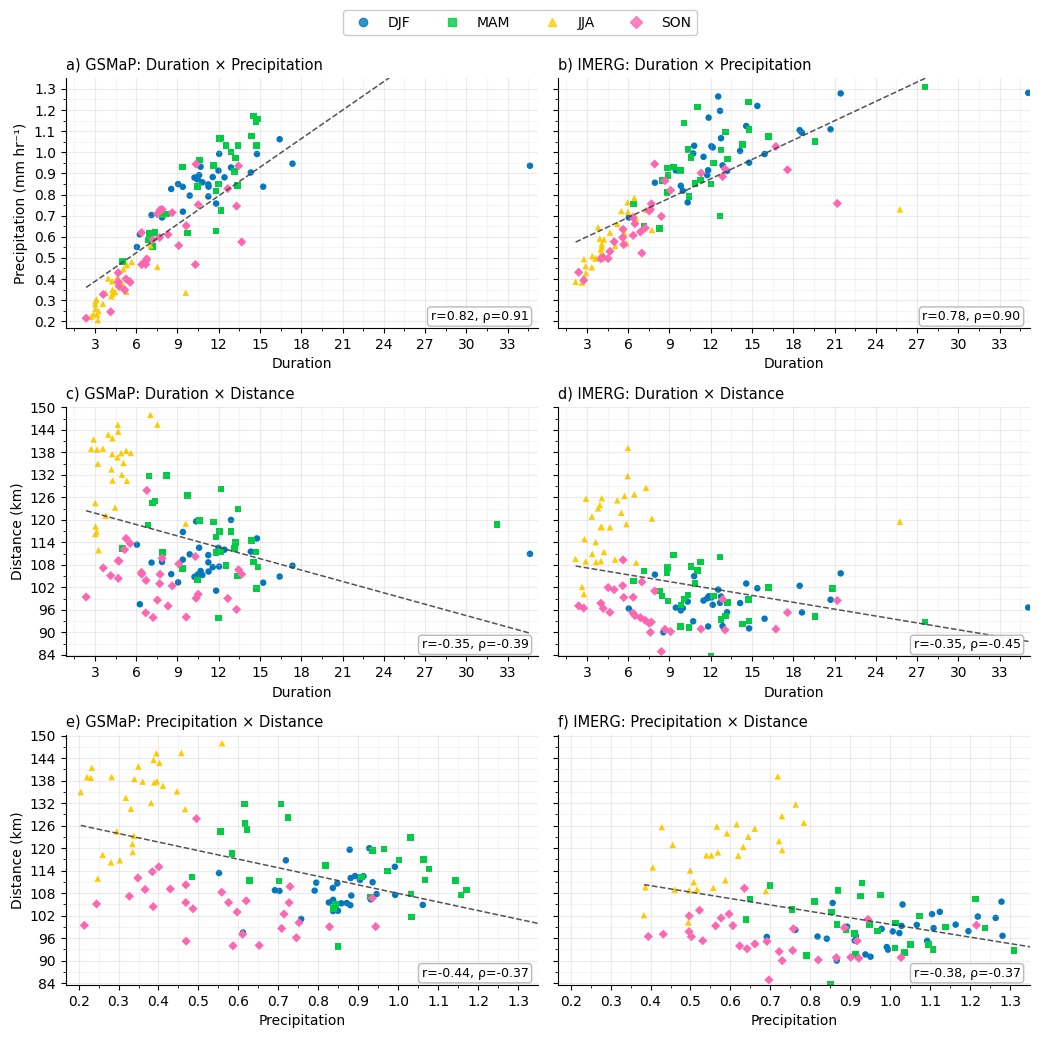

In [244]:
# Colect seasonal p99 values for gsmap_distance
seasonal_p99_gsmap = {}
SEASON_LABELS = {12:"DJF", 1:"DJF", 2:"DJF",
                 3:"MAM", 4:"MAM", 5:"MAM",
                 6:"JJA", 7:"JJA", 8:"JJA",
                 9:"SON",10:"SON",11:"SON"}
SEASON_ORDER = gsmap_distance.index.to_series().dt.month.map(SEASON_LABELS).unique()
for season in SEASON_ORDER:
    season_months = [k for k,v in SEASON_LABELS.items() if v == season]
    seasonal_data = gsmap_distance[gsmap_distance.index.month.isin(season_months)]
    seasonal_p99_gsmap[season] = seasonal_data['p99'].values
seasonal_p99_gsmap = pd.DataFrame(seasonal_p99_gsmap)

seasonal_p99_imerg = {}
for season in SEASON_ORDER:
    season_months = [k for k,v in SEASON_LABELS.items() if v == season]
    seasonal_data = imerg_distance[imerg_distance.index.month.isin(season_months)]
    seasonal_p99_imerg[season] = seasonal_data['p99'].values
seasonal_p99_imerg = pd.DataFrame(seasonal_p99_imerg)

# merge dataframes
seasonal_p99 = pd.concat(
    [seasonal_p99_gsmap.add_suffix('_GSMAP'),
     seasonal_p99_imerg.add_suffix('_IMERG')],
    axis=1
)

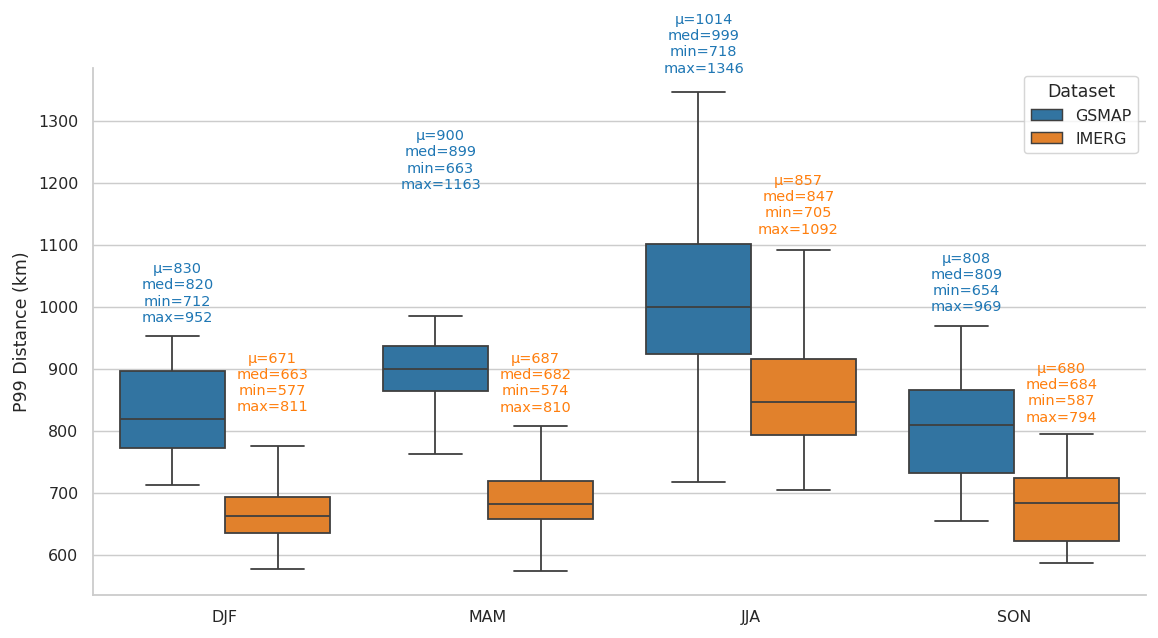

In [262]:
SEASON_ORDER = ["DJF","MAM","JJA","SON"]
PALETTE = {"GSMAP": "#1f77b4", "IMERG": "#ff7f0e"}  # ajuste se quiser


def boxplot_with_stats(df):
    # Reorganiza para formato longo
    long = df.melt(var_name="col", value_name="value")
    long[["season","dataset"]] = long["col"].str.split("_", expand=True)
    long.drop(columns="col", inplace=True)
    long = long[["season","dataset","value"]]
    
    # Ordem e cores
    SEASON_ORDER = ["DJF","MAM","JJA","SON"]
    PALETTE = {"GSMAP": "#1f77b4", "IMERG": "#ff7f0e"}

    sns.set_theme(style="whitegrid", context="paper")
    fig, ax = plt.subplots(figsize=(9,5), dpi=130)

    # Boxplot principal
    sns.boxplot(
        data=long, x="season", y="value", hue="dataset",
        order=SEASON_ORDER, hue_order=["GSMAP","IMERG"],
        palette=PALETTE, dodge=True, showfliers=False, ax=ax
    )

    # Calcula estatísticas e adiciona texto acima de cada box
    offsets = {"GSMAP": -0.18, "IMERG": 0.18}
    for season in SEASON_ORDER:
        for dataset in ["GSMAP", "IMERG"]:
            vals = long.query("season == @season and dataset == @dataset")["value"].dropna()
            if len(vals) == 0:
                continue
            mean = vals.mean()
            med = vals.median()
            vmin = vals.min()
            vmax = vals.max()
            x = SEASON_ORDER.index(season) + offsets[dataset]
            y = vals.max()
            txt = f"μ={mean:.0f}\nmed={med:.0f}\nmin={vmin:.0f}\nmax={vmax:.0f}"
            ax.text(x, y*1.02, txt, ha="center", va="bottom", fontsize=8, color=PALETTE[dataset])

    ax.set_ylabel("P99 Distance (km)")
    ax.set_xlabel("")
    # ax.set_title("Distribuição sazonal — GSMaP vs IMERG")
    ax.legend(title="Dataset", frameon=True, loc="upper right")
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()


ax = boxplot_with_stats(
    seasonal_p99
)
plt.show()

In [ ]:
# Map seasons
gsmap_amazon_traj_gpd['season'] = gsmap_amazon_traj_gpd['end_timestamp'].dt.month.map(SEASON_LABELS)
imerg_amazon_traj_gpd['season'] = imerg_amazon_traj_gpd['end_timestamp'].dt.month.map(SEASON_LABELS)

In [274]:
# Get seasonal median values
month_gsmap_med = seasonal_p99_gsmap.describe().T['50%']
month_imerg_med = seasonal_p99_imerg.describe().T['50%']

In [ ]:
# Filter events by season and get only p99 >= median
gsmap_seasonal_filtered = gsmap_amazon_traj_gpd[
    gsmap_amazon_traj_gpd.apply(
        lambda row: row['start_end_haversine_km'] >= month_gsmap_med[row['season']],
        axis=1
    )
]

imerg_seasonal_filtered = imerg_amazon_traj_gpd[
    imerg_amazon_traj_gpd.apply(
        lambda row: row['start_end_haversine_km'] >= month_imerg_med[row['season']],
        axis=1
    )
]

In [380]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator

def plot_two_trajectories_stacked(
    gdf_top, gdf_bottom, amazon,
    titles=("a) GSMaP (por estação)", "b) IMERG (por estação)"),
    season_coloring: bool = True,
    season_cmap: str = "tab10",
    traj_color: str = "#444444",
    alpha: float = 0.15, lw: float = 0.35,
    start_color="blue", end_color="red", ms=2,
    extent = None,               # [lon_min, lon_max, lat_min, lat_max]
    land_color = "#f2efe9", ocean_color = "#dfeaf7",
    coastline_color = "gray",
    xticks = None, yticks = None,            # listas de valores em graus; se None, infere do extent
    grid_ls="--", grid_lw=0.6, grid_alpha=0.5,
    figsize=(10, 12), dpi=130
):

    # Base (contorno) em 4326
    amazon4326 = amazon.to_crs(epsg=4326)

    fig, axes = plt.subplots(
        2, 1, figsize=figsize, dpi=dpi,
        subplot_kw={'projection': ccrs.PlateCarree()},
        constrained_layout=False
    )

    def setup_axes(ax):
        # fundo: oceano/continente
        ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, zorder=0)
        ax.add_feature(cfeature.LAND,  facecolor=land_color,  zorder=0)
        ax.coastlines(color=coastline_color, linewidth=0.6, zorder=1)
        if extent is not None:
            ax.set_extent(extent)
        # grade com rótulos de lon/lat
        gl = ax.gridlines(draw_labels=True, linestyle=grid_ls, linewidth=grid_lw,
                          color="gray", alpha=grid_alpha, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        if (xticks is None) and (extent is not None):
            x0, x1 = extent[0], extent[1]
            # passo heurístico de 5°
            vals = np.arange(np.ceil(x0/5)*5, np.floor(x1/5)*5 + 0.1, 5)
            gl.xlocator = FixedLocator(vals)
        elif xticks is not None:
            gl.xlocator = FixedLocator(xticks)
        if (yticks is None) and (extent is not None):
            y0, y1 = extent[2], extent[3]
            vals = np.arange(np.ceil(y0/5)*5, np.floor(y1/5)*5 + 0.1, 5)
            gl.ylocator = FixedLocator(vals)
        elif yticks is not None:
            gl.ylocator = FixedLocator(yticks)
        return gl

    for i, (ax, gdf, title) in enumerate(zip(axes, [gdf_top, gdf_bottom], titles)):
        amazon4326.boundary.plot(ax=ax, edgecolor='black', linewidth=1.0, zorder=2)
        setup_axes(ax)

        traj = gdf.set_geometry('trajectory')
        if season_coloring:
            traj.plot(ax=ax, column='season', cmap=season_cmap,
                    alpha=alpha, linewidth=lw, legend=False, zorder=3)
        else:
            traj.plot(ax=ax, color=traj_color, alpha=alpha, linewidth=lw, zorder=3)

        if 'start_geometry' in gdf.columns:
            gdf.set_geometry('start_geometry').plot(
                ax=ax, color=start_color, markersize=ms, marker='o', alpha=0.5,
                label='Start Points', zorder=4
            )
        if 'end_geometry' in gdf.columns:
            gdf.set_geometry('end_geometry').plot(
                ax=ax, color=end_color, markersize=ms, marker='X', alpha=0.5,
                label='End Points', zorder=4
            )

        handles, labels = ax.get_legend_handles_labels()
        if season_coloring:
            # adiciona estações manualmente para legenda completa
            from matplotlib.lines import Line2D
            season_handles = [
                Line2D([0], [0], color=c, lw=2.5, label=s)
                for s, c in zip(["DJF", "MAM", "JJA", "SON"], plt.get_cmap(season_cmap).colors[:4])
            ]
            handles.extend(season_handles)
        ax.legend(
            handles, labels,
            loc='lower left', frameon=True, framealpha=1,
            fontsize=8, handlelength=1.8
        )

        ax.set_title(title, loc='left', fontsize=12, pad=2)            

    return fig, axes


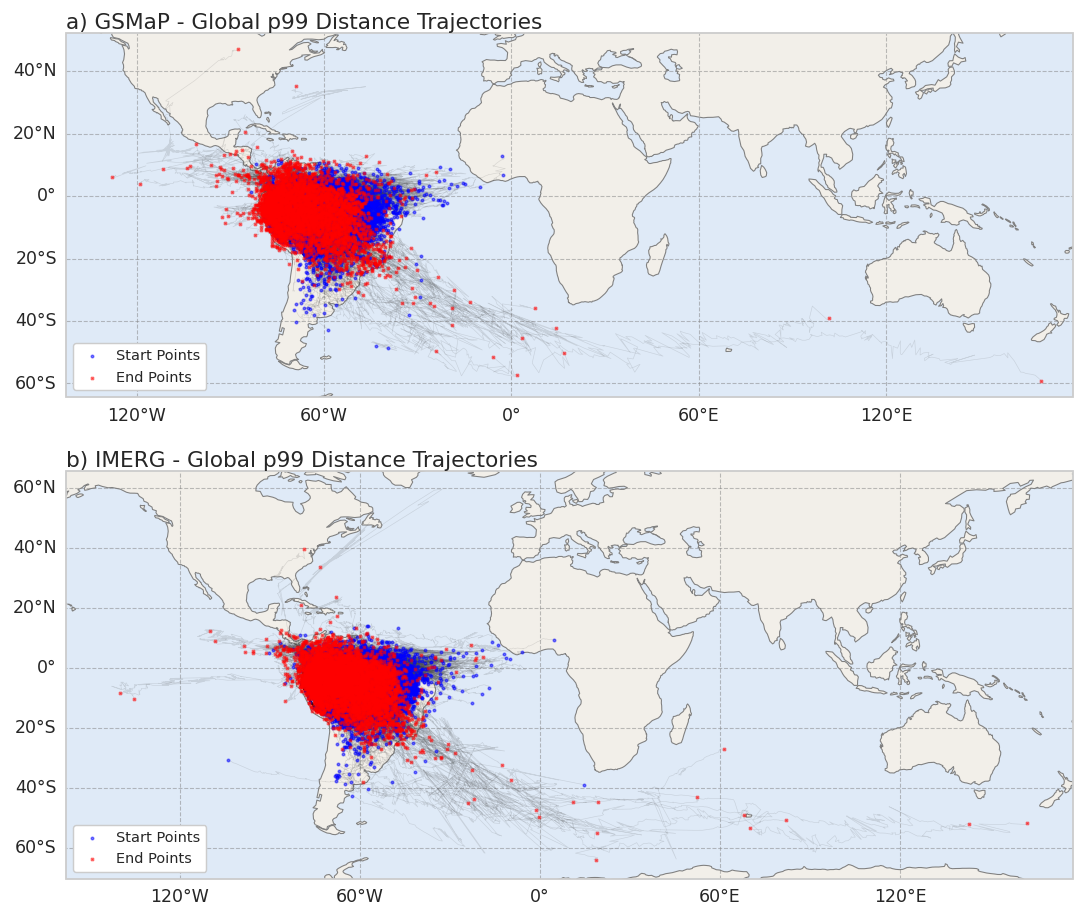

In [382]:
fig, axes = plot_two_trajectories_stacked(
    gsmap_seasonal_filtered,
    imerg_seasonal_filtered,
    amazon,
    titles=("a) GSMaP - Global p99 Distance Trajectories", "b) IMERG - Global p99 Distance Trajectories"),
    season_coloring=False,    
    traj_color="#444444",
    # extent=(-80, -45, -20, 10),
    xticks=None, yticks=None)
plt.subplots_adjust(hspace=-0.38)
plt.show()


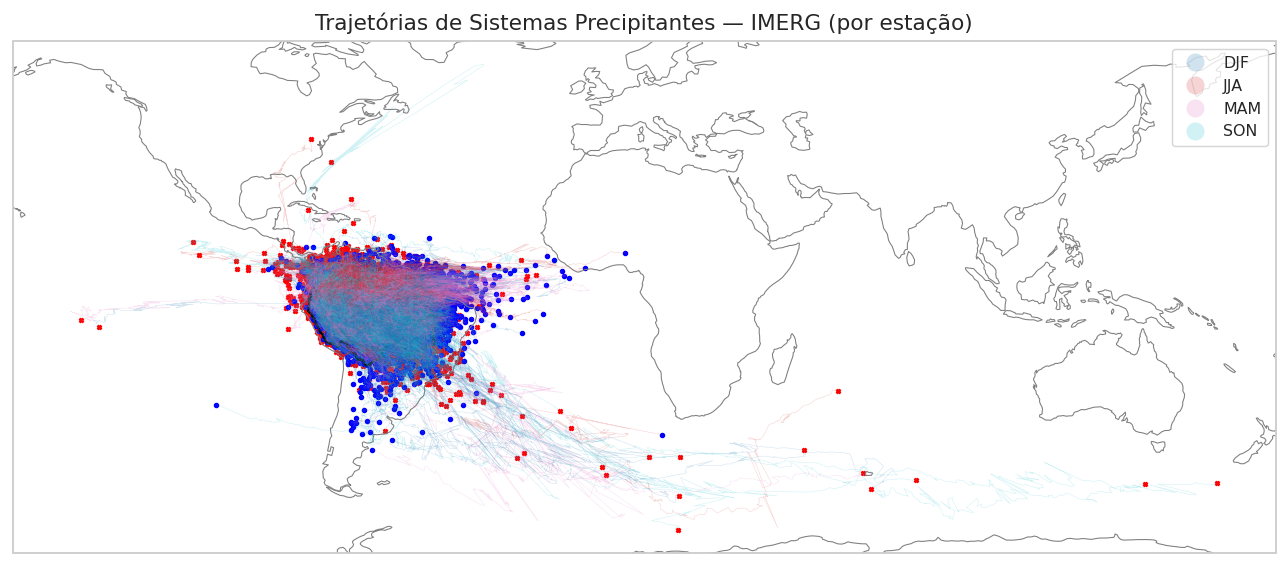

In [310]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       dpi=130)

# Base: contorno da Amazônia
base = amazon.to_crs(epsg=4326).boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plotagem direta por estação
gdf = imerg_seasonal_filtered.set_geometry('trajectory')
gdf.plot(ax=base,
         column='season',           # cores automáticas por estação
         alpha=0.2,
         linewidth=0.3,
         legend=True,
         cmap='tab10')              # paleta colorida padrão

imerg_seasonal_filtered.set_geometry('end_geometry').plot(
    ax=base,
    color='red',
    markersize=5,
    marker='X',
    label='End Points'
)

imerg_seasonal_filtered.set_geometry('start_geometry').plot(
    ax=base,
    color='blue',
    markersize=5,
    marker='o',
    label='Start Points'
)

# Aparência
ax.coastlines(color='gray', linewidth=0.6)
# ax.set_extent([-80, -45, -20, 10])
ax.set_title('Trajetórias de Sistemas Precipitantes — IMERG (por estação)', fontsize=12)
plt.tight_layout()
plt.show()

In [222]:
gsmap_ds_amz_duration_trend = daskCompute(dask_mann_kendall(gsmap_ds_amz_duration, test="original", alpha=0.05, normalize_slope=False), dask_client)
imerg_ds_amz_duration_trend = daskCompute(dask_mann_kendall(imerg_ds_amz_duration, test="original", alpha=0.05, normalize_slope=False), dask_client)

gsmap_ds_amz_precipitation_trend = daskCompute(dask_mann_kendall(gsmap_ds_amz_precipitation, test="original", alpha=0.05, normalize_slope=False), dask_client)
imerg_ds_amz_precipitation_trend = daskCompute(dask_mann_kendall(imerg_ds_amz_precipitation, test="original", alpha=0.05, normalize_slope=False), dask_client)

gsmap_distance = build_monthly_distance(gsmap_amazon_traj_gpd,
                                 time_col="end_timestamp",
                                 dist_col="start_end_haversine_km",
                                 filter_max_km=None)
gsmap_distance.index.rename('time', inplace=True)
gsmap_distance_ds = gsmap_distance['mean'].to_xarray()
gsmap_distance_trend = daskCompute(dask_mann_kendall(gsmap_distance_ds, test="original", alpha=0.05), dask_client)

imerg_distance = build_monthly_distance(imerg_amazon_traj_gpd,
                                 time_col="end_timestamp",
                                 dist_col="start_end_haversine_km",
                                 filter_max_km=None)
imerg_distance.index.rename('time', inplace=True)
imerg_distance_ds = imerg_distance['mean'].to_xarray()
imerg_distance_trend = daskCompute(dask_mann_kendall(imerg_distance_ds, test="original", alpha=0.05), dask_client)

/home/helvecio.neto/tese/plots.py:1349: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  d = d.set_index(d[time_col].dt.to_period("M").dt.to_timestamp())
/home/helvecio.neto/tese/plots.py:1349: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  d = d.set_index(d[time_col].dt.to_period("M").dt.to_timestamp())


In [223]:

import pymannkendall as mk
res = mk.original_test(gsmap_ds_amz_duration.values, alpha=0.05)
res.slope
print("GSMAP duration slope", gsmap_ds_amz_duration_trend.slope.values)
print("IMERG duration slope", imerg_ds_amz_duration_trend.slope.values)
print("GSMAP precipitation slope", gsmap_ds_amz_precipitation_trend.slope.values)
print("IMERG precipitation slope", imerg_ds_amz_precipitation_trend.slope.values)
print("GSMAP distance slope", gsmap_distance_trend.slope.values)
print("IMERG distance slope", imerg_distance_trend.slope.values)
print("-" * 30)
print("GSMaP duration intercept:", gsmap_ds_amz_duration_trend.intercept.values)
print("IMERG duration intercept:", imerg_ds_amz_duration_trend.intercept.values)
print("GSMaP precipitation intercept:", gsmap_ds_amz_precipitation_trend.intercept.values)
print("IMERG precipitation intercept:", imerg_ds_amz_precipitation_trend.intercept.values)
print("GSMaP distance intercept:", gsmap_distance_trend.intercept.values)
print("IMERG distance intercept:", imerg_distance_trend.intercept.values)

GSMAP duration slope 0.005428257
IMERG duration slope 0.0016800024
GSMAP precipitation slope 4.3222855e-05
IMERG precipitation slope -0.0013117476
GSMAP distance slope -0.002018682
IMERG distance slope -0.013295172
------------------------------
GSMaP duration intercept: 8.10896
IMERG duration intercept: 8.769962
GSMaP precipitation intercept: 0.6691133
IMERG precipitation intercept: 0.89704335
GSMaP distance intercept: 111.83509
IMERG distance intercept: 100.35118


In [227]:
gsmap_distance = gsmap_distance.reset_index()
imerg_distance = imerg_distance.reset_index()

Text(0, 0.5, 'Distance (km)')

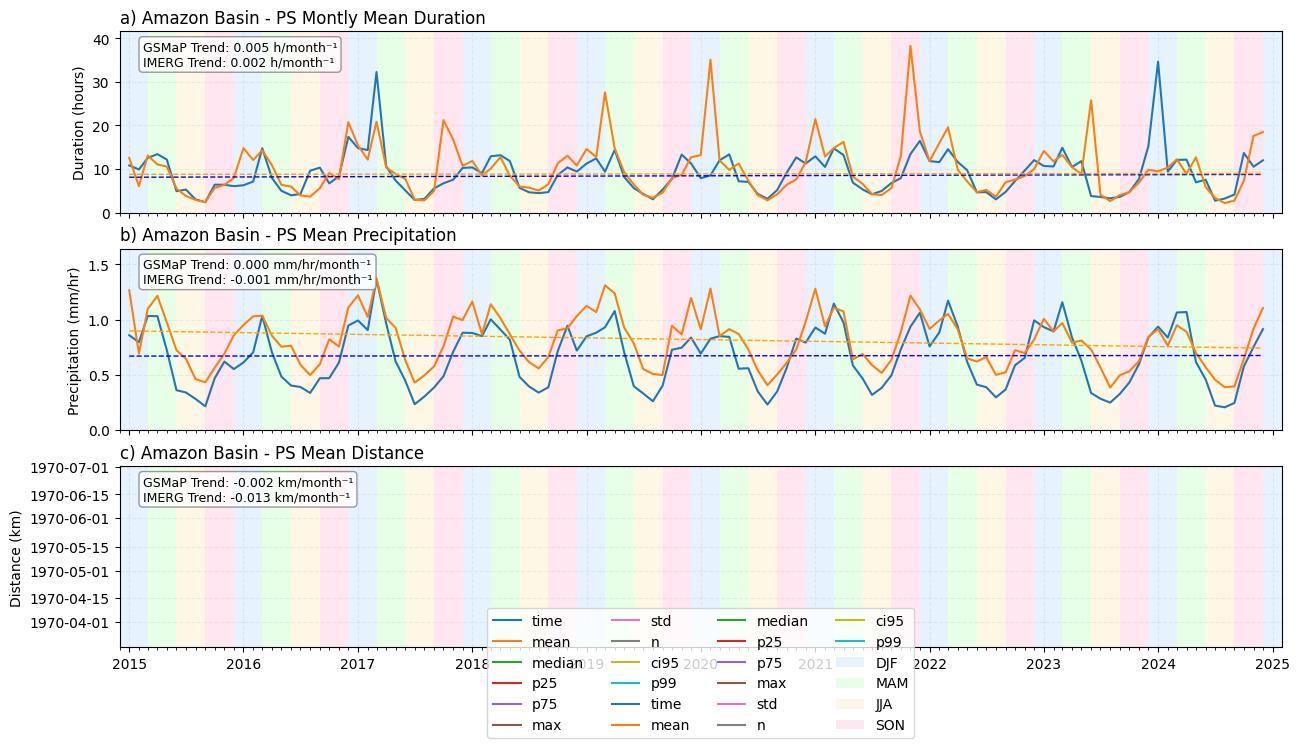

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8), dpi=100, sharex=True)
gsmap_ds_amz_duration.plot(ax=ax[0], label="GSMaP Duration")
imerg_ds_amz_duration.plot(ax=ax[0], label="IMERG Duration")

gsmap_ds_amz_precipitation.plot(ax=ax[1], label="GSMaP Precipitation")
imerg_ds_amz_precipitation.plot(ax=ax[1], label="IMERG Precipitation")

gsmap_distance.plot(ax=ax[2], label="GSMaP")
imerg_distance.plot(ax=ax[2], label="IMERG")

x_vals = np.arange(len(imerg_distance['time']))

gsmap_dur_intercept = gsmap_ds_amz_duration_trend['intercept'].item()
gsmap_dur_slope = gsmap_ds_amz_duration_trend['slope'].item() 
ax[0].plot(gsmap_ds_amz_duration['time'].values, gsmap_dur_intercept + gsmap_dur_slope * x_vals, linestyle='--', label='GSMaP Trend', linewidth=1, color='blue')
imerg_dur_intercept = imerg_ds_amz_duration_trend['intercept'].item()
imerg_dur_slope = imerg_ds_amz_duration_trend['slope'].item() 
ax[0].plot(imerg_ds_amz_duration['time'].values, imerg_dur_intercept + imerg_dur_slope * x_vals, linestyle='--', label='IMERG Trend', linewidth=1, color='orange')

gsmap_prec_intercept = gsmap_ds_amz_precipitation_trend['intercept'].item()
gsmap_prec_slope = gsmap_ds_amz_precipitation_trend['slope'].item() 
ax[1].plot(gsmap_ds_amz_precipitation['time'].values, gsmap_prec_intercept + gsmap_prec_slope * x_vals, linestyle='--', label='GSMaP Trend', linewidth=1, color='blue')
imerg_prec_intercept = imerg_ds_amz_precipitation_trend['intercept'].item()
imerg_prec_slope = imerg_ds_amz_precipitation_trend['slope'].item() 
ax[1].plot(imerg_ds_amz_precipitation['time'].values, imerg_prec_intercept + imerg_prec_slope * x_vals, linestyle='--', label='IMERG Trend', linewidth=1, color='orange')

gsmap_dist_intercept = gsmap_distance_trend['intercept'].item()
gsmap_dist_slope = gsmap_distance_trend['slope'].item() 
ax[2].plot(gsmap_distance['time'].values, gsmap_dist_intercept + gsmap_dist_slope * x_vals, linestyle='--', label='GSMaP Trend', linewidth=1, color='blue')
imerg_dist_intercept = imerg_distance_trend['intercept'].item()
imerg_dist_slope = imerg_distance_trend['slope'].item() 
ax[2].plot(imerg_distance['time'].values, imerg_dist_intercept + imerg_dist_slope * x_vals, linestyle='--', label='IMERG Trend', linewidth=1, color='orange')

# Remove xlabels from all but the last plot
for i in range(3):
    ax[i].set_xlabel("")
    ax[i].grid(True, linestyle='--', alpha=0.2)
# Add seasonal backgrounds
extended_start = pd.to_datetime('2014-12-01', format='%Y-%m-%d')
extended_end = pd.to_datetime('2025-01-15', format='%Y-%m-%d')
y_max_vals = [gsmap_ds_amz_duration.max().item()*1.2,
              gsmap_ds_amz_precipitation.max().item()*1.2,
              gsmap_distance['mean'].max().item()*1.1]
season_colors = plots.add_seasonal_backgrounds([ax[0], ax[1], ax[2]], extended_start, extended_end, y_max_vals)
# Set limits for x-axis and y-axis
ax[2].set_xlim(pd.to_datetime('2014-12-01', format='%Y-%m-%d'), pd.to_datetime('2025-01-31', format='%Y-%m-%d'))
ax[0].set_ylim(0, y_max_vals[0])
ax[1].set_ylim(0, y_max_vals[1])
ax[2].set_ylim(75, y_max_vals[2])
# Show all year ticks 
ax[2].xaxis.set_major_locator(mdates.YearLocator())
ax[2].xaxis.set_minor_locator(mdates.MonthLocator())

# Legend
season_patches = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, alpha=1) for color in season_colors.values()]
handles_ax1, labels_ax1 = ax[0].get_legend_handles_labels()
handles_ax2, labels_ax2 = ax[1].get_legend_handles_labels()
handles_ax3, labels_ax3 = ax[2].get_legend_handles_labels()
ax[2].legend(handles=handles_ax3 + season_patches, 
             labels=labels_ax3 + list(season_colors.keys()), ncol=4,
             loc='lower center', bbox_to_anchor=(0.5, -.5), borderaxespad=0.)

# Add textbox with trend results
duration_text = f"GSMaP Trend: {gsmap_dur_slope:.3f} h/month⁻¹\nIMERG Trend: {imerg_dur_slope:.3f} h/month⁻¹"
precipitation_text = f"GSMaP Trend: {gsmap_prec_slope:.3f} mm/hr/month⁻¹\nIMERG Trend: {imerg_prec_slope:.3f} mm/hr/month⁻¹"
distance_text = f"GSMaP Trend: {gsmap_dist_slope:.3f} km/month⁻¹\nIMERG Trend: {imerg_dist_slope:.3f} km/month⁻¹"
ax[0].text(0.02, 0.95, duration_text, transform=ax[0].transAxes, fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
ax[1].text(0.02, 0.95, precipitation_text, transform=ax[1].transAxes, fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
ax[2].text(0.02, 0.95, distance_text, transform=ax[2].transAxes, fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

# Add titles
ax[0].set_title("a) Amazon Basin - PS Montly Mean Duration", loc='left', y=1)
ax[0].set_ylabel("Duration (hours)")

ax[1].set_title("b) Amazon Basin - PS Mean Precipitation", loc='left', y=1)
ax[1].set_ylabel("Precipitation (mm/hr)")

ax[2].set_title("c) Amazon Basin - PS Mean Distance ", loc='left', y=1)
ax[2].set_ylabel("Distance (km)")

In [55]:
gsmap_ds_amz_djf = gsmap_ds_amz.sel(time=gsmap_ds_amz['time.season'] == 'DJF')
gsmap_ds_amz_mam = gsmap_ds_amz.sel(time=gsmap_ds_amz['time.season'] == 'MAM')
gsmap_ds_amz_jja = gsmap_ds_amz.sel(time=gsmap_ds_amz['time.season'] == 'JJA')
gsmap_ds_amz_son = gsmap_ds_amz.sel(time=gsmap_ds_amz['time.season'] == 'SON')

imerg_ds_amz_djf = imerg_ds_amz.sel(time=imerg_ds_amz['time.season'] == 'DJF')
imerg_ds_amz_mam = imerg_ds_amz.sel(time=imerg_ds_amz['time.season'] == 'MAM')
imerg_ds_amz_jja = imerg_ds_amz.sel(time=imerg_ds_amz['time.season'] == 'JJA')
imerg_ds_amz_son = imerg_ds_amz.sel(time=imerg_ds_amz['time.season'] == 'SON')


# Compute seasonal maps
gsmap_ds_amz_djf_fam_duration = compute(gsmap_ds_amz_djf['fam-duration'].sum(dim='time', skipna=True) / gsmap_ds_amz_djf['fam-density'].sum(dim='time', skipna=True) / 60)

[                                        ] | 0% Completed |  1.0s

[                                        ] | 0% Completed | 26min  1.8s

KeyboardInterrupt: 

In [ ]:
gsmap_ds_amz_djf_fam_duration.plot()

In [ ]:
gsmap_ds_amz_duration = compute(spatial_weighted_mean_series(gsmap_ds_amz['fam-duration'] / 60, gsmap_ds_amz['fam-density']))
imerg_ds_amz_duration = compute(spatial_weighted_mean_series(imerg_ds_amz['fam-duration'] / 60, imerg_ds_amz['fam-density']))

gsmap_ds_amz_duration_trend = compute(dask_mann_kendall(gsmap_ds_amz_duration, test="original", alpha=0.05, normalize_slope=False))
imerg_ds_amz_duration_trend = compute(dask_mann_kendall(imerg_ds_amz_duration, test="original", alpha=0.05, normalize_slope=False))


gsmap_ds_amz_precipitation = compute(spatial_weighted_mean_series(gsmap_ds_amz['fam-mean_values'], gsmap_ds_amz['fam-density']))
imerg_ds_amz_precipitation = compute(spatial_weighted_mean_series(imerg_ds_amz['fam-mean_values'], imerg_ds_amz['fam-density']))

In [52]:
gsmap_ds_amz_djf

<xarray.Dataset> Size: 17GB
Dimensions:             (time: 30, lat: 1200, lon: 3600)
Coordinates:
  * time                (time) datetime64[ns] 240B 2015-01-01 ... 2024-12-01
  * lat                 (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.85 59.95
  * lon                 (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.9
Data variables: (12/33)
    fam-Non-Continuous  (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    fam-Continuous      (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    clu-NEW             (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    clu-CON             (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    clu-SPL             (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    clu-MRG             (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ...                  ...
    fam-far_            (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    clu-far_            (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    fam-initiation      (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    fam-dissipation     (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    fam-density         (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    clu-density         (time, lat, lon) float32 518MB dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
Attributes: (12/14)
    start_time:       2015-01-01 00:00:00
    end_time:         2015-01-31 23:00:00
    threshold_level:  0
    min_duration:     0
    min_distance:     0
    status_count:     True
    ...               ...
    frequency:        1MS
    title:            Spatial Information of Systems
    institution:      National Institute for Space Research (INPE)
    source:           pyfortracc
    history:          Created 2025-11-05 09:28:11
    references:       Leal Neto H.B. & Calheiros A. J. p. (2024). pyfortracc:...

Text(0.0, 1, 'f) IMERG Final V07 - Dominance')

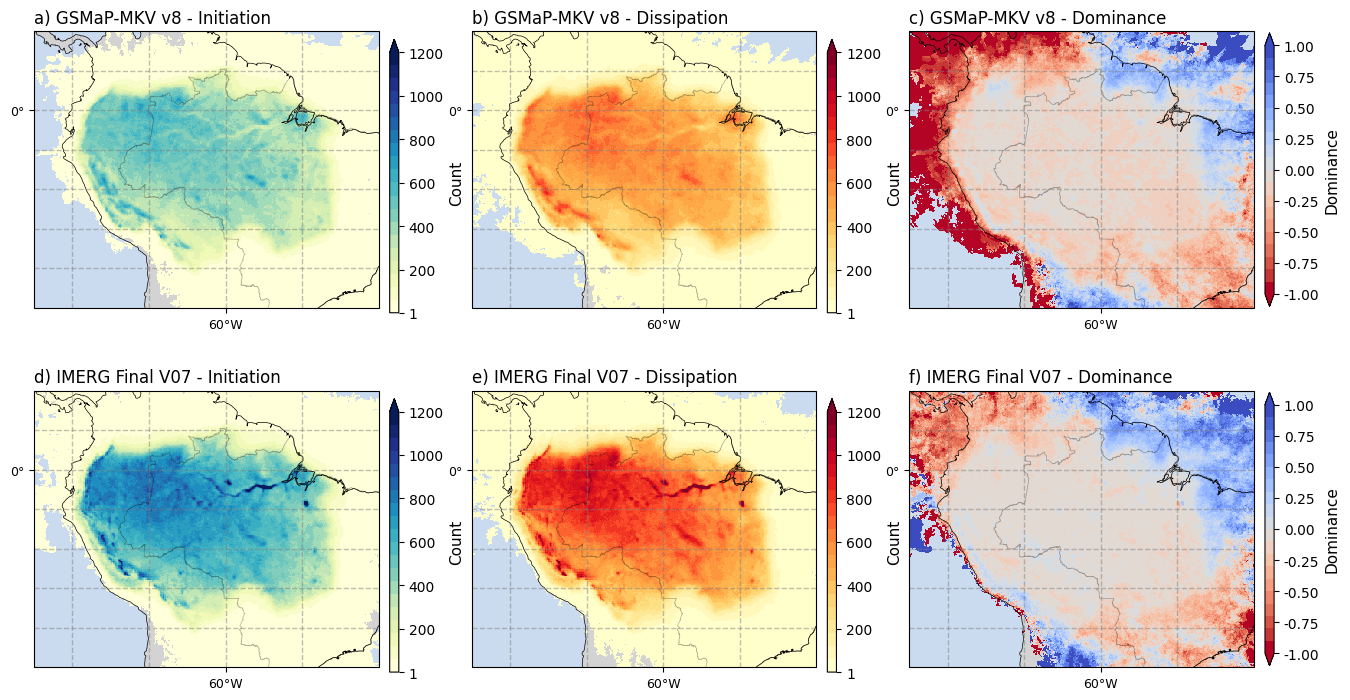

In [48]:
gsmap_initiation_amz = compute(gsmap_ds_amz['fam-initiation'].sum(dim="time"))
gsmap_dissipation_amz = compute(gsmap_ds_amz['fam-dissipation'].sum(dim="time"))

imerg_initiation_amz = compute(imerg_ds_amz['fam-initiation'].sum(dim="time"))
imerg_dissipation_amz = compute(imerg_ds_amz['fam-dissipation'].sum(dim="time"))

# Compute dominance
gsmap_map_dominance = (gsmap_initiation_amz - gsmap_dissipation_amz) / (gsmap_initiation_amz + gsmap_dissipation_amz)
imerg_map_dominance = (imerg_initiation_amz - imerg_dissipation_amz) / (imerg_initiation_amz + imerg_dissipation_amz)


fig, axes = plt.subplots(2, 3, figsize=(16, 14), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()},
                                                          gridspec_kw={'hspace': -0.5, 'wspace': 0.2})

plots.map(gsmap_initiation_amz, figsize=(12, 8), title='', ax=axes[0, 0],
           ylim=[-25, 10], xlim=[-85, -40],cmap_num=20, cmap='YlGnBu', max_val=1200, min_val=1,
cbar_label='Count', cbar_extend='max', cbar_fraction=0.025,  cbar_shrink=0.75)

plots.map(gsmap_dissipation_amz, figsize=(12, 8), title='', ax=axes[0, 1],
           ylim=[-25, 10], xlim=[-85, -40],cmap_num=20, cmap='YlOrRd', max_val=1200, min_val=1,
cbar_label='Count', cbar_extend='max', cbar_fraction=0.025,  cbar_shrink=0.75)
plots.map(gsmap_map_dominance, figsize=(12, 8), title='', ax=axes[0, 2],
           ylim=[-25, 10], xlim=[-85, -40],cmap_num=20, cmap='coolwarm_r', max_val=1, min_val=-1,
cbar_label='Dominance', cbar_extend='both', cbar_fraction=0.025,  cbar_shrink=0.75, cbar_format="%.2f")

plots.map(imerg_initiation_amz, figsize=(12, 8), title='', ax=axes[1, 0],
           ylim=[-25, 10], xlim=[-85, -40],cmap_num=20, cmap='YlGnBu', max_val=1200, min_val=1,
cbar_label='Count', cbar_extend='max', cbar_fraction=0.025,  cbar_shrink=0.75)
plots.map(imerg_dissipation_amz, figsize=(12, 8), title='', ax=axes[1, 1],
           ylim=[-25, 10], xlim=[-85, -40],cmap_num=20, cmap='YlOrRd', max_val=1200, min_val=1,
cbar_label='Count', cbar_extend='max', cbar_fraction=0.025,  cbar_shrink=0.75)
plots.map(imerg_map_dominance, figsize=(12, 8), title='', ax=axes[1, 2],
           ylim=[-25, 10], xlim=[-85, -40],cmap_num=20, cmap='coolwarm_r', max_val=1, min_val=-1,
cbar_label='Dominance', cbar_extend='both', cbar_fraction=0.025,  cbar_shrink=0.75, cbar_format="%.2f")
axes[0,0].set_title(f"a) {gsmap_name} - Initiation", loc='left', y=1)
axes[0,1].set_title(f"b) {gsmap_name} - Dissipation", loc='left', y=1)
axes[0,2].set_title(f"c) {gsmap_name} - Dominance", loc='left', y=1)
axes[1,0].set_title(f"d) {imerg_name} - Initiation", loc='left', y=1)
axes[1,1].set_title(f"e) {imerg_name} - Dissipation", loc='left', y=1)
axes[1,2].set_title(f"f) {imerg_name} - Dominance", loc='left', y=1)

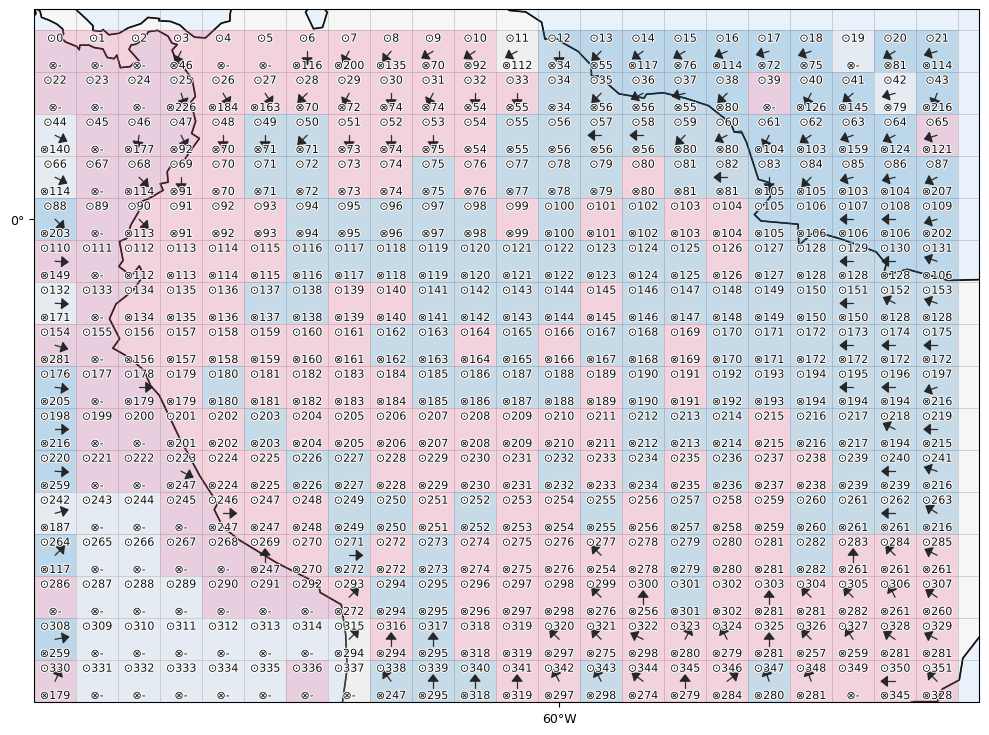

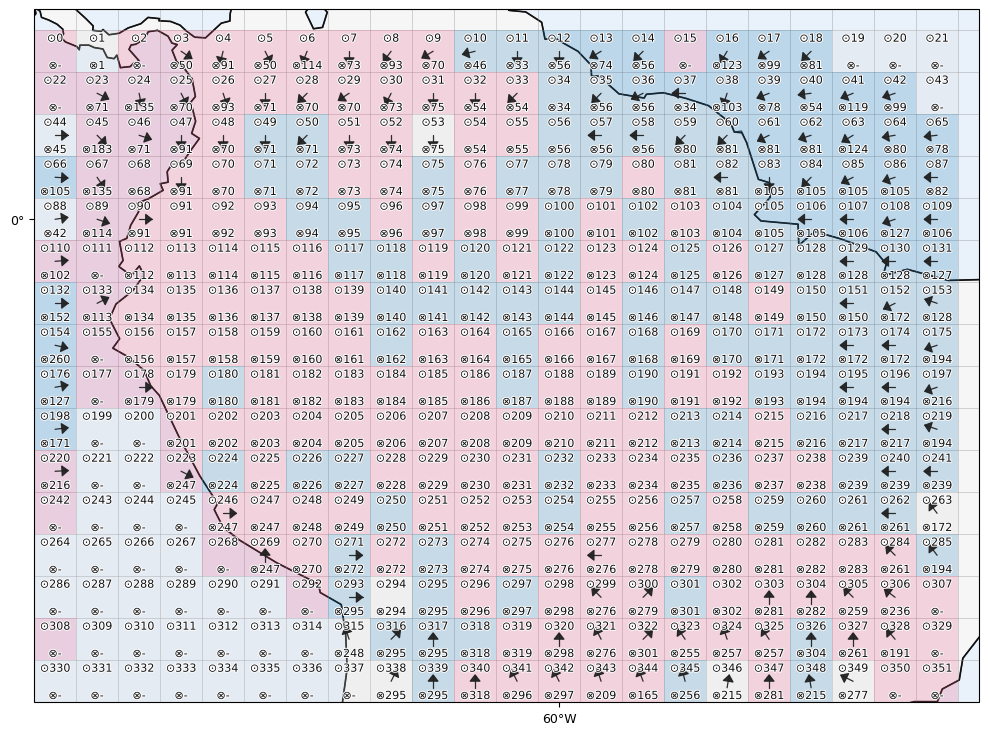

In [26]:
gsmap_amazon = summarize_quadrants(
    gsmap_amazon_traj_gpd,
    start_col="start_geometry",
    end_col="end_geometry",
    season_col="seasonal_category",
    season=None,
    lon_min=-85, lon_max=-40,
    lat_min=-23, lat_max=10,
    step=2
)

plots.trajectory_map(
    gsmap_amazon,
    extent=(-85, -40, -23, 10),
    step=2,
    mode="full",
    show_counts=True,
    annotate_empty=True,
    draw_arrows=True,
    arrow_len_frac=0.75, 
    q_fontsize=8,
    d_fontsize=8,
    q_top_pad_frac=0.2,  
    d_bot_pad_frac=0.15,    
)

imerg_amazon = summarize_quadrants(
    imerg_amazon_traj_gpd,
    start_col="start_geometry",
    end_col="end_geometry",
    season_col="seasonal_category",
    season=None,
    lon_min=-85, lon_max=-40,
    lat_min=-23, lat_max=10,
    step=2
)

plots.trajectory_map(
    imerg_amazon,
    extent=(-85, -40, -23, 10),
    step=2,
    mode="full",
    show_counts=True,
    annotate_empty=True,
    draw_arrows=True,
    arrow_len_frac=0.75,
    q_fontsize=8,
    d_fontsize=8,
    q_top_pad_frac=0.2,
    d_bot_pad_frac=0.15,
)


In [29]:
df_test = gsmap_amazon_traj_gpd.head(1000)

<GeoAxes: >

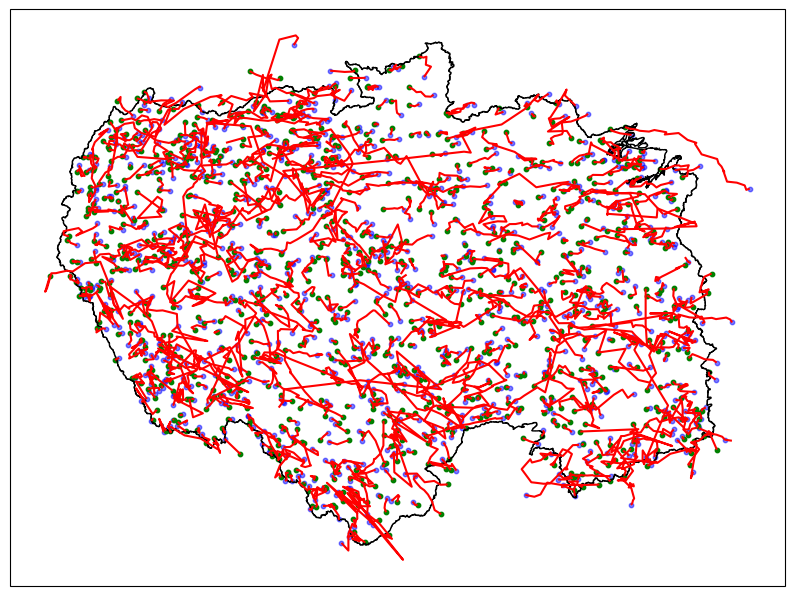

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': cartopy.crs.PlateCarree()})
base = amazon.to_crs(epsg=4326).boundary.plot(ax=ax, edgecolor='black', linewidth=1)
df_test.set_geometry('start_geometry').plot(ax=base, color='blue', markersize=10, alpha=0.5)
df_test.set_geometry('end_geometry').plot(ax=base, color='green', markersize=10, label='Start')
df_test.set_geometry('trajectory').plot(ax=base, color='red', markersize=10, label='End')

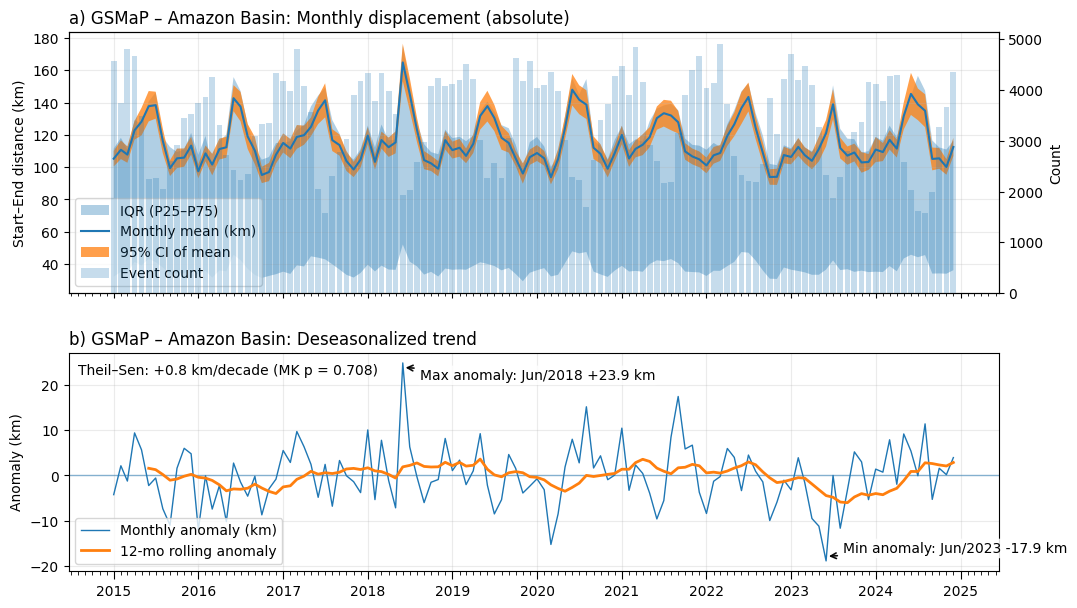

In [ ]:
monthly = build_monthly_distance(gsmap_amazon_traj_gpd,
                                 time_col="end_timestamp",
                                 dist_col="start_end_haversine_km",
                                 filter_max_km=None)
fig, axes = plot_monthly_displacement_evolution(monthly,
                                                title_prefix="GSMaP – Amazon Basin")
plt.show()

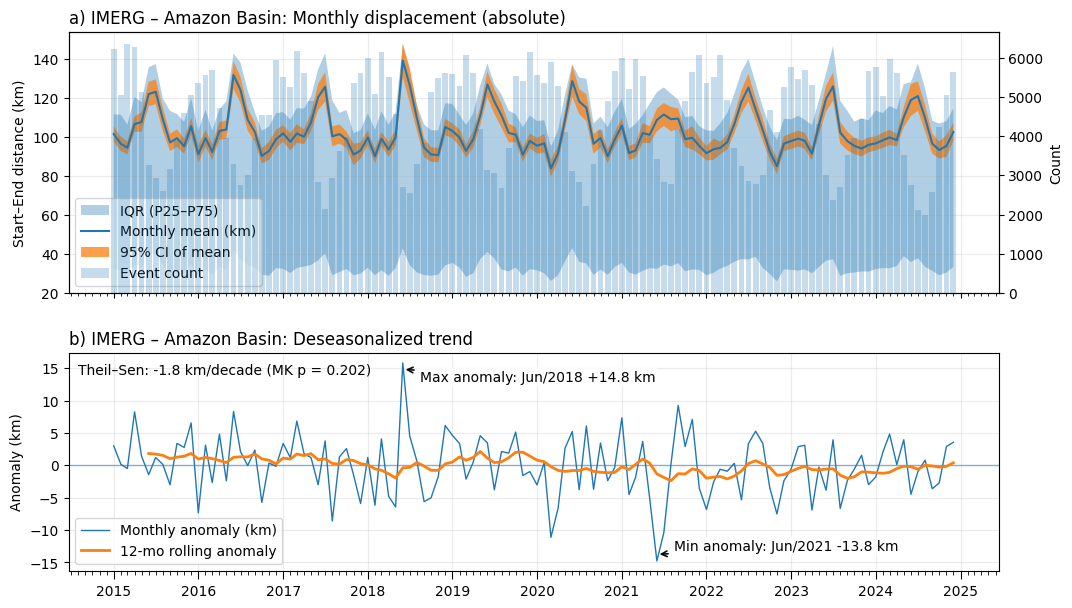

In [ ]:
monthly = build_monthly_distance(imerg_amazon_traj_gpd,
                                 time_col="end_timestamp",
                                 dist_col="start_end_haversine_km",
                                 filter_max_km=None)
fig, axes = plot_monthly_displacement_evolution(monthly,
                                                title_prefix="IMERG – Amazon Basin")
plt.show()

In [ ]:
fig = plot_ps_initiation_dissipation_dominance(
    gsmap_laplata_traj_gpd,
    extent=[-75, -35, -40, -10],
    base_map=laplata,
    title='GSMaP',
    counts_log=False,
    q1_km=None,
    dominance_mode='asymmetry',
    vmax=250,
)

fig = plot_ps_initiation_dissipation_dominance(
    imerg_laplata_traj_gpd,
    extent=[-75, -35, -40, -10],
    base_map=laplata,
    title='IMERG',
    counts_log=False,
    q1_km=None,
    dominance_mode='asymmetry',
    title_sequency=('d)', 'e)', 'f)'),
    vmax=250,
)